# Chap 5.4 PixelCNN

----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----



In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

import matplotlib.pyplot as plt
from pathlib import Path
import os


In [2]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters

In [3]:
IMAGE_SIZE = 32
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare Data

2025-05-07 19:06:39.665914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-07 19:06:39.665937: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-07 19:06:39.665944: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-07 19:06:39.665974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-07 19:06:39.665991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


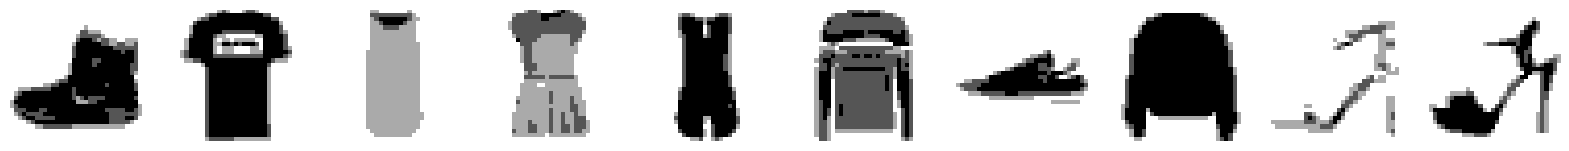

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

# Show some items of clothing from the training set
display(input_data)

## 2. PixelCNN

In [5]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

# Residual Block
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

#
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 32, 32, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 32, 32, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 32, 32, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 32, 32, 128)       53504     
 Block)                                                      

## 3. Train PixelCNN

Epoch 1/150


2025-05-07 19:06:41.723611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-07 19:06:41.847324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


469/469 [==============================] - ETA: 0s - loss: 0.3305
Saved to ./temp/output/generated_img_000.png


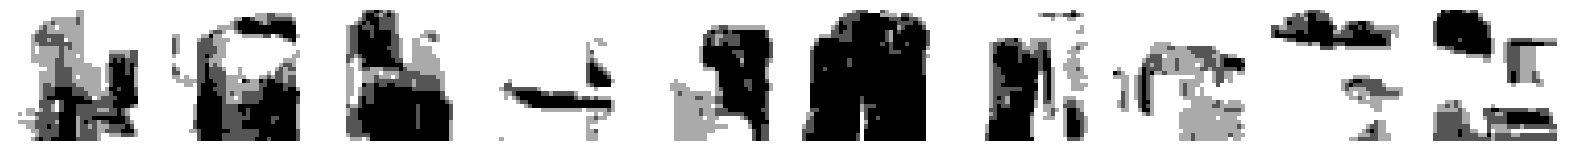

469/469 [==============================] - 61s 123ms/step - loss: 0.3305
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.2425
Saved to ./temp/output/generated_img_001.png


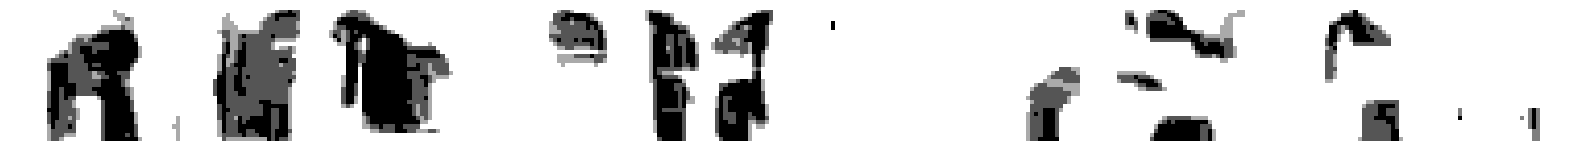

469/469 [==============================] - 58s 123ms/step - loss: 0.2425
Epoch 3/150
469/469 [==============================] - ETA: 0s - loss: 0.2362
Saved to ./temp/output/generated_img_002.png


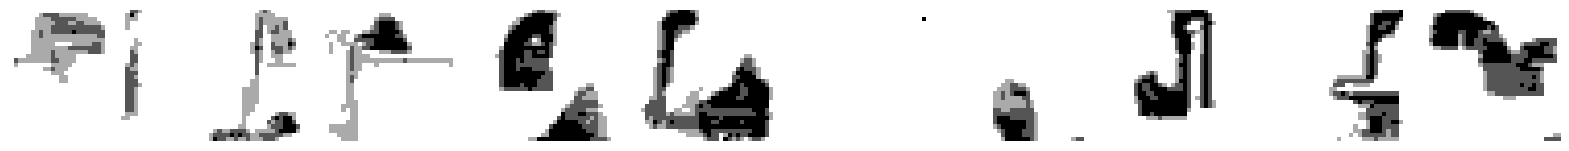

469/469 [==============================] - 58s 123ms/step - loss: 0.2362
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.2325
Saved to ./temp/output/generated_img_003.png


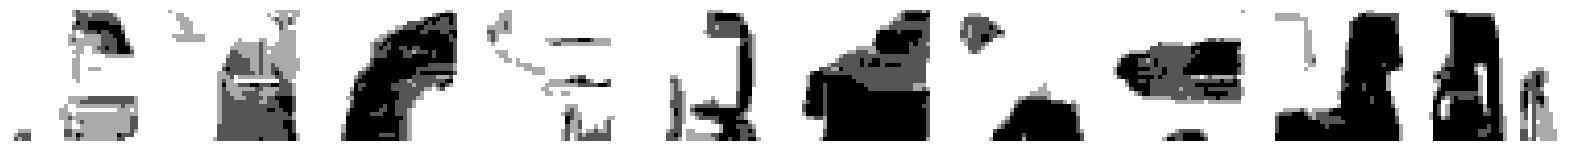

469/469 [==============================] - 58s 124ms/step - loss: 0.2325
Epoch 5/150
469/469 [==============================] - ETA: 0s - loss: 0.2303
Saved to ./temp/output/generated_img_004.png


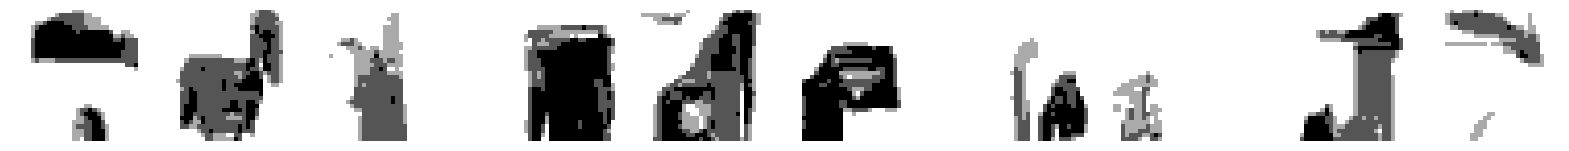

469/469 [==============================] - 71s 151ms/step - loss: 0.2303
Epoch 6/150
469/469 [==============================] - ETA: 0s - loss: 0.2284
Saved to ./temp/output/generated_img_005.png


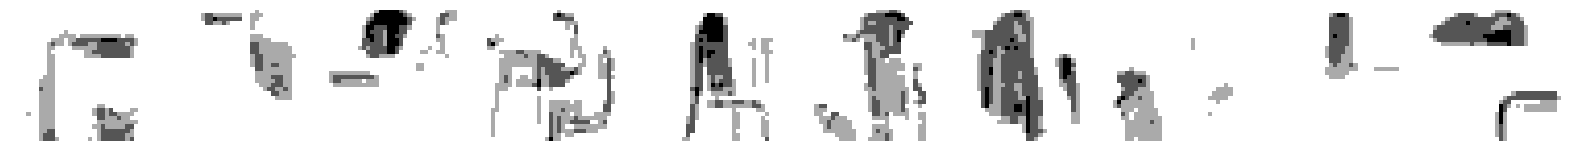

469/469 [==============================] - 64s 137ms/step - loss: 0.2284
Epoch 7/150
469/469 [==============================] - ETA: 0s - loss: 0.2272
Saved to ./temp/output/generated_img_006.png


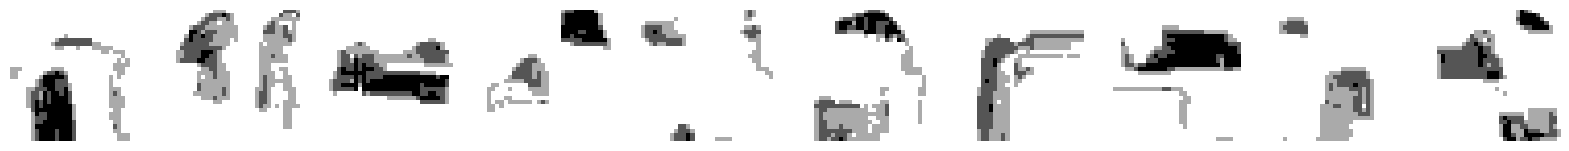

469/469 [==============================] - 60s 128ms/step - loss: 0.2272
Epoch 8/150
469/469 [==============================] - ETA: 0s - loss: 0.2257
Saved to ./temp/output/generated_img_007.png


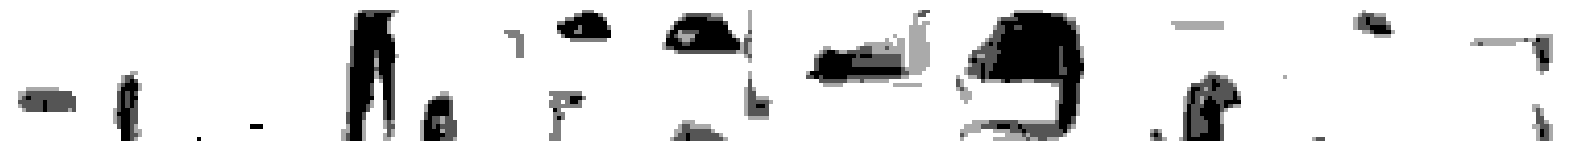

469/469 [==============================] - 60s 127ms/step - loss: 0.2257
Epoch 9/150
469/469 [==============================] - ETA: 0s - loss: 0.2249
Saved to ./temp/output/generated_img_008.png


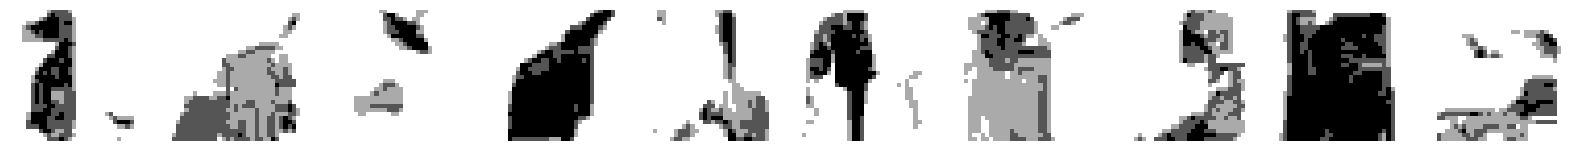

469/469 [==============================] - 58s 124ms/step - loss: 0.2249
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.2238
Saved to ./temp/output/generated_img_009.png


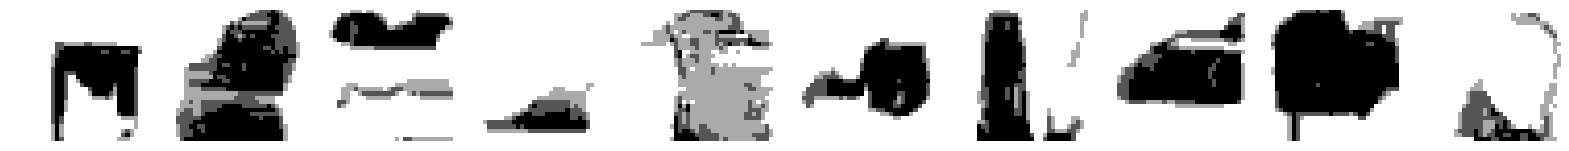

469/469 [==============================] - 59s 126ms/step - loss: 0.2238
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.2229
Saved to ./temp/output/generated_img_010.png


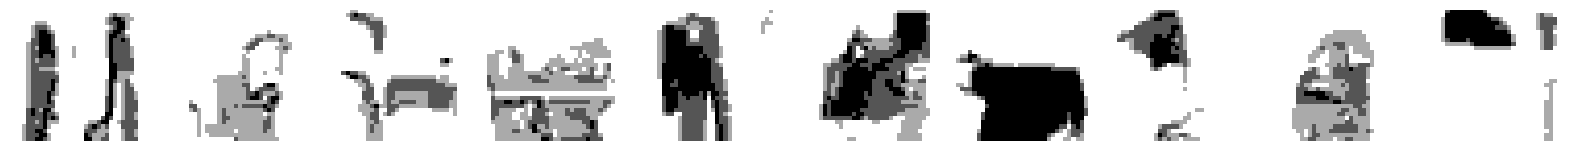

469/469 [==============================] - 59s 127ms/step - loss: 0.2229
Epoch 12/150
469/469 [==============================] - ETA: 0s - loss: 0.2222
Saved to ./temp/output/generated_img_011.png


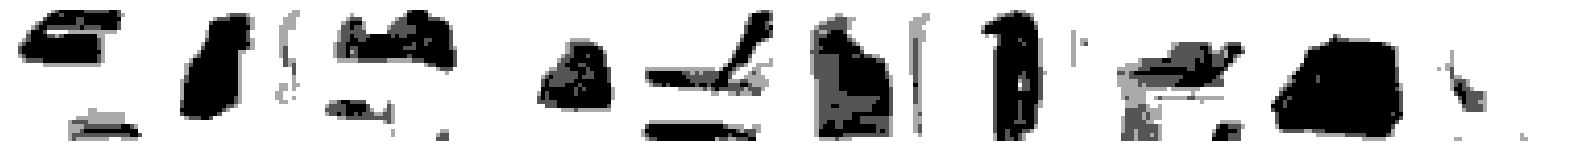

469/469 [==============================] - 59s 126ms/step - loss: 0.2222
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.2217
Saved to ./temp/output/generated_img_012.png


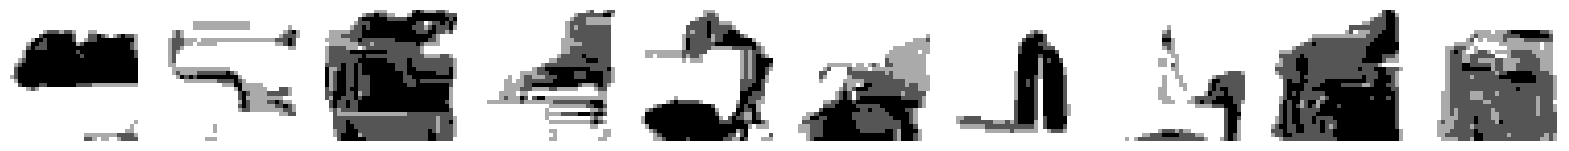

469/469 [==============================] - 58s 124ms/step - loss: 0.2217
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.2208
Saved to ./temp/output/generated_img_013.png


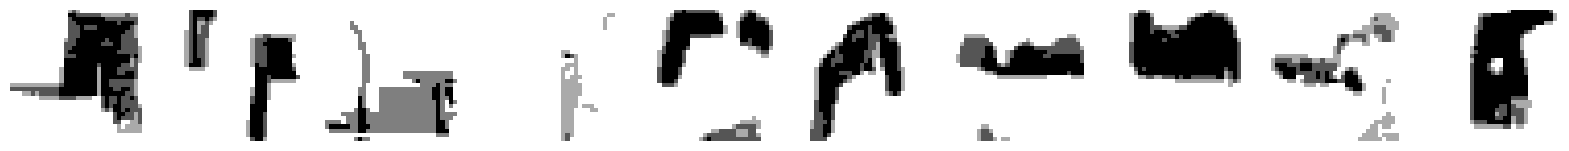

469/469 [==============================] - 58s 124ms/step - loss: 0.2208
Epoch 15/150
469/469 [==============================] - ETA: 0s - loss: 0.2202
Saved to ./temp/output/generated_img_014.png


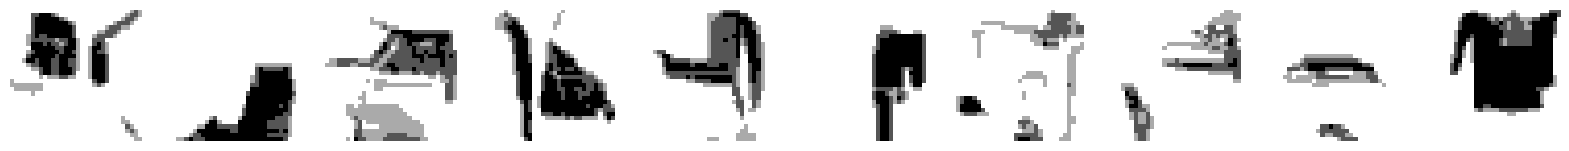

469/469 [==============================] - 57s 122ms/step - loss: 0.2202
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.2195
Saved to ./temp/output/generated_img_015.png


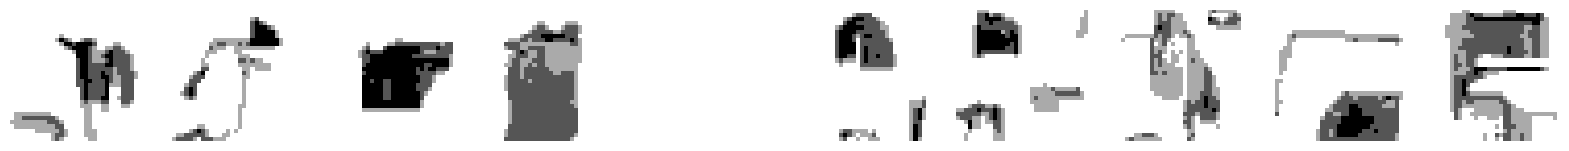

469/469 [==============================] - 58s 124ms/step - loss: 0.2195
Epoch 17/150
469/469 [==============================] - ETA: 0s - loss: 0.2191
Saved to ./temp/output/generated_img_016.png


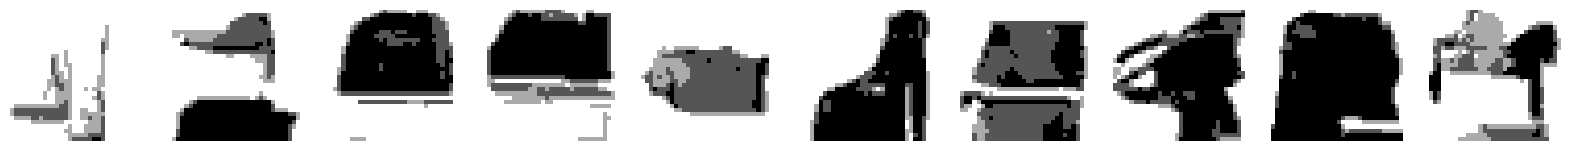

469/469 [==============================] - 57s 122ms/step - loss: 0.2191
Epoch 18/150
469/469 [==============================] - ETA: 0s - loss: 0.2186
Saved to ./temp/output/generated_img_017.png


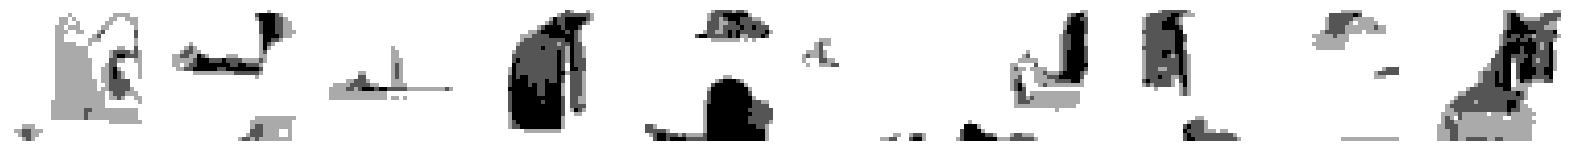

469/469 [==============================] - 57s 123ms/step - loss: 0.2186
Epoch 19/150
469/469 [==============================] - ETA: 0s - loss: 0.2180
Saved to ./temp/output/generated_img_018.png


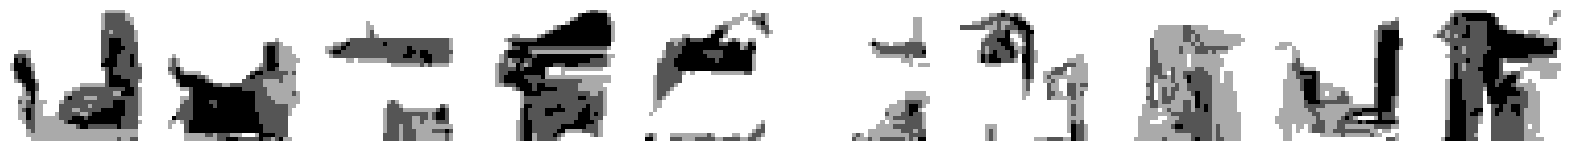

469/469 [==============================] - 57s 123ms/step - loss: 0.2180
Epoch 20/150
469/469 [==============================] - ETA: 0s - loss: 0.2176
Saved to ./temp/output/generated_img_019.png


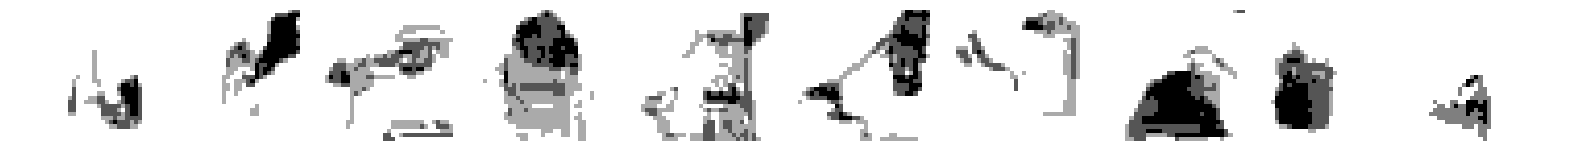

469/469 [==============================] - 59s 126ms/step - loss: 0.2176
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.2172
Saved to ./temp/output/generated_img_020.png


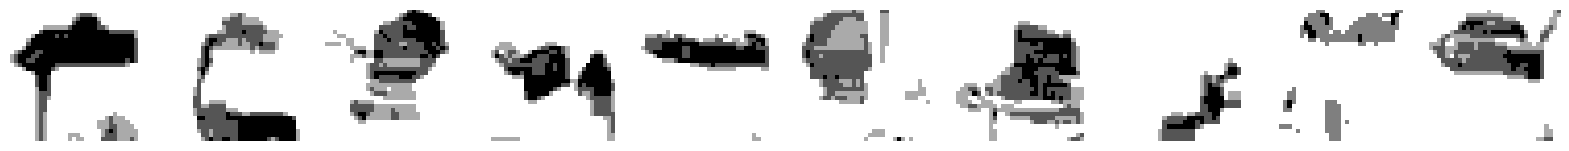

469/469 [==============================] - 57s 122ms/step - loss: 0.2172
Epoch 22/150
469/469 [==============================] - ETA: 0s - loss: 0.2167
Saved to ./temp/output/generated_img_021.png


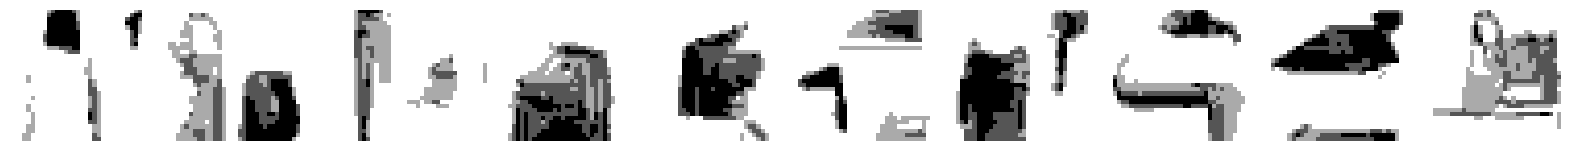

469/469 [==============================] - 58s 123ms/step - loss: 0.2167
Epoch 23/150
469/469 [==============================] - ETA: 0s - loss: 0.2164
Saved to ./temp/output/generated_img_022.png


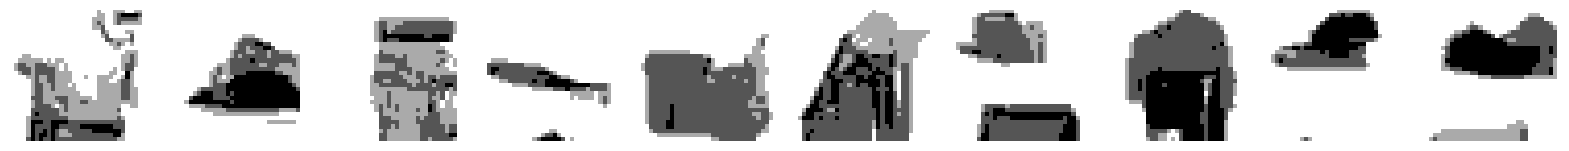

469/469 [==============================] - 57s 122ms/step - loss: 0.2164
Epoch 24/150
469/469 [==============================] - ETA: 0s - loss: 0.2160
Saved to ./temp/output/generated_img_023.png


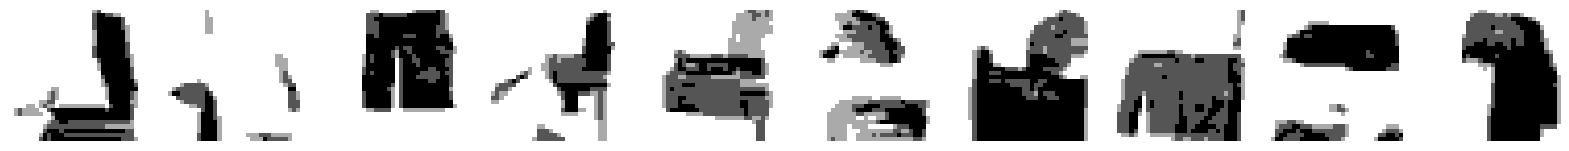

469/469 [==============================] - 59s 125ms/step - loss: 0.2160
Epoch 25/150
469/469 [==============================] - ETA: 0s - loss: 0.2156
Saved to ./temp/output/generated_img_024.png


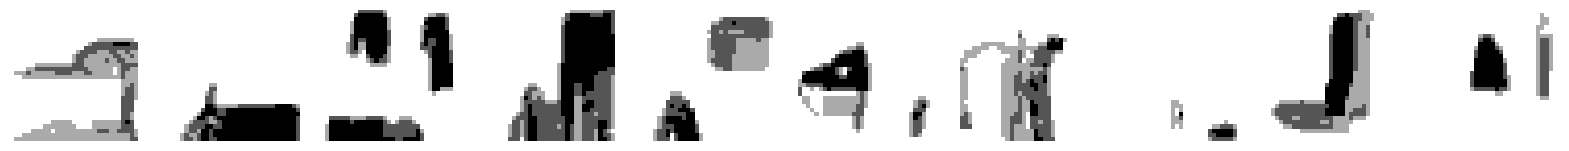

469/469 [==============================] - 58s 124ms/step - loss: 0.2156
Epoch 26/150
469/469 [==============================] - ETA: 0s - loss: 0.2153
Saved to ./temp/output/generated_img_025.png


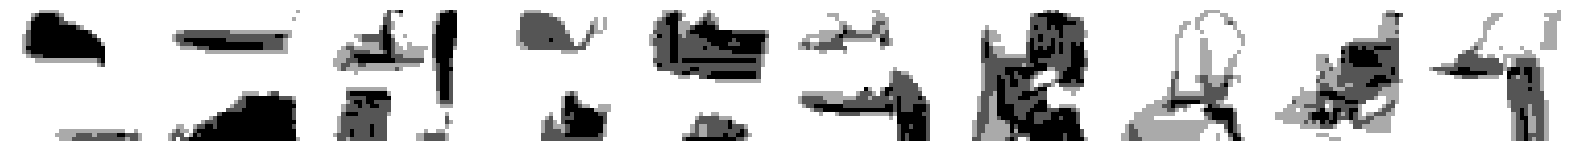

469/469 [==============================] - 59s 125ms/step - loss: 0.2153
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.2151
Saved to ./temp/output/generated_img_026.png


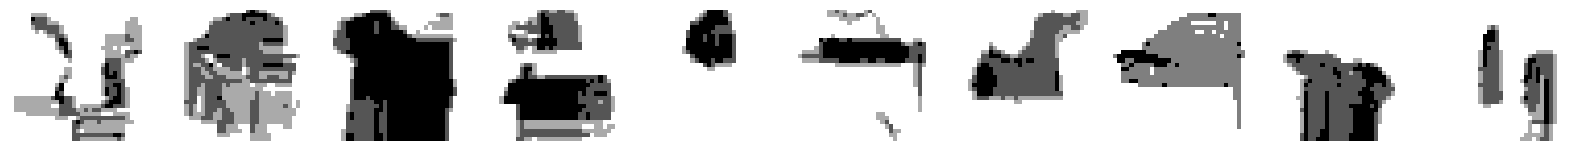

469/469 [==============================] - 57s 122ms/step - loss: 0.2151
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.2146
Saved to ./temp/output/generated_img_027.png


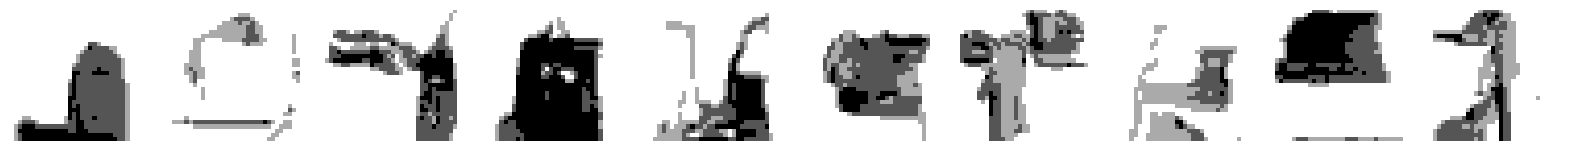

469/469 [==============================] - 58s 123ms/step - loss: 0.2146
Epoch 29/150
469/469 [==============================] - ETA: 0s - loss: 0.2143
Saved to ./temp/output/generated_img_028.png


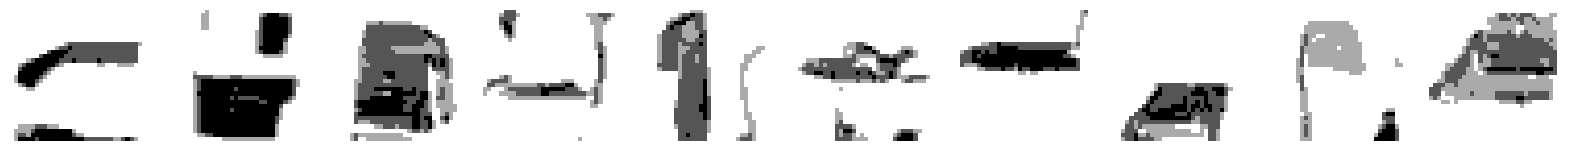

469/469 [==============================] - 57s 121ms/step - loss: 0.2143
Epoch 30/150
469/469 [==============================] - ETA: 0s - loss: 0.2142
Saved to ./temp/output/generated_img_029.png


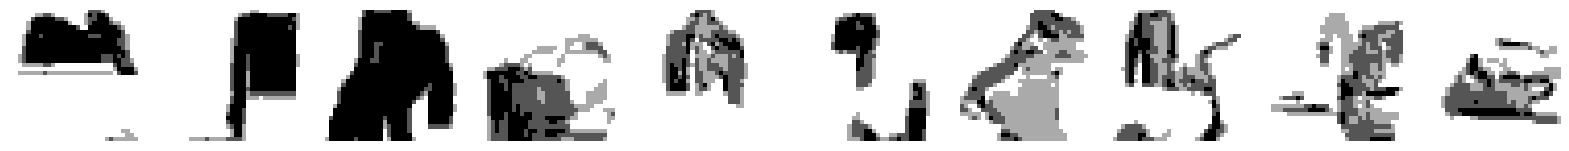

469/469 [==============================] - 57s 121ms/step - loss: 0.2142
Epoch 31/150
469/469 [==============================] - ETA: 0s - loss: 0.2138
Saved to ./temp/output/generated_img_030.png


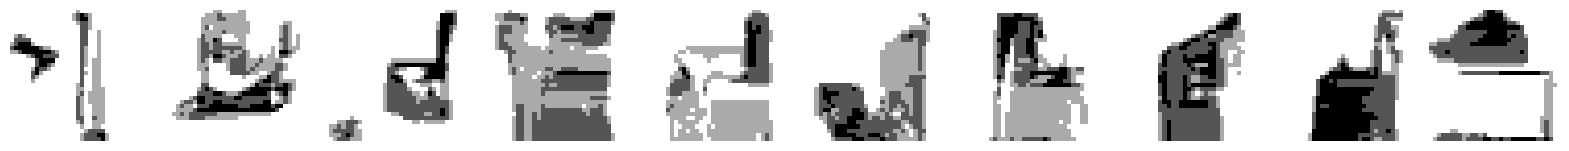

469/469 [==============================] - 57s 121ms/step - loss: 0.2138
Epoch 32/150
469/469 [==============================] - ETA: 0s - loss: 0.2136
Saved to ./temp/output/generated_img_031.png


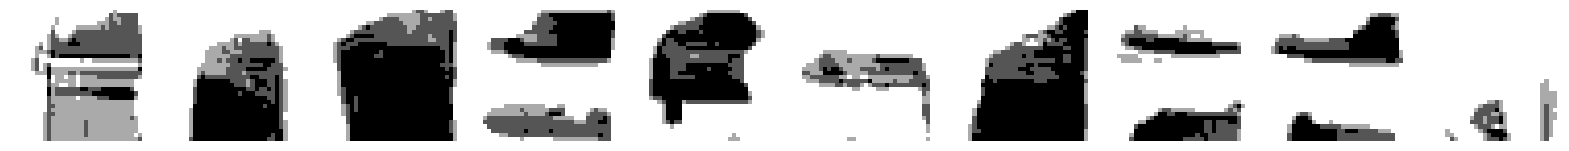

469/469 [==============================] - 57s 121ms/step - loss: 0.2136
Epoch 33/150
469/469 [==============================] - ETA: 0s - loss: 0.2133
Saved to ./temp/output/generated_img_032.png


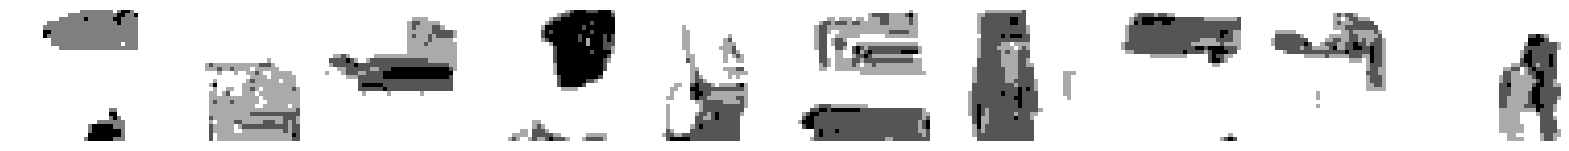

469/469 [==============================] - 57s 121ms/step - loss: 0.2133
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.2132
Saved to ./temp/output/generated_img_033.png


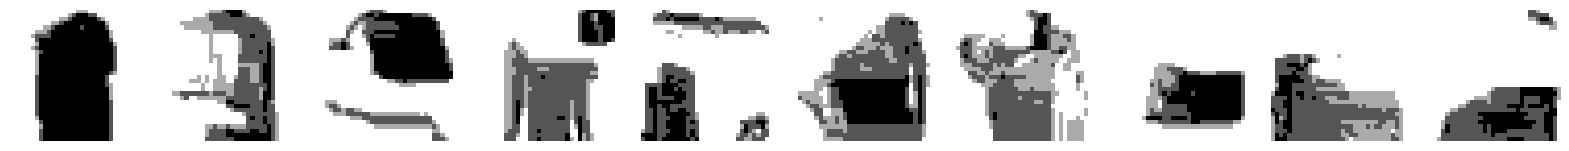

469/469 [==============================] - 57s 122ms/step - loss: 0.2132
Epoch 35/150
469/469 [==============================] - ETA: 0s - loss: 0.2128
Saved to ./temp/output/generated_img_034.png


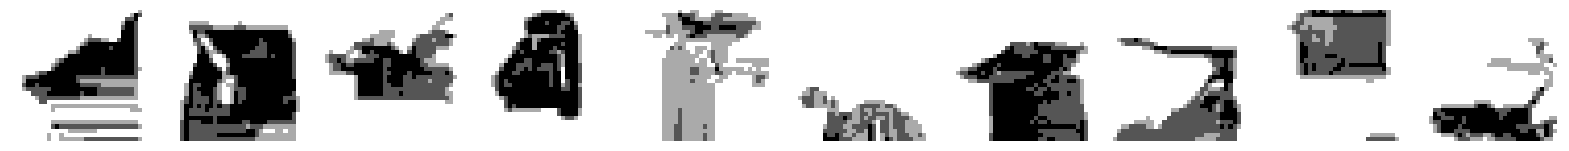

469/469 [==============================] - 57s 121ms/step - loss: 0.2128
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.2127
Saved to ./temp/output/generated_img_035.png


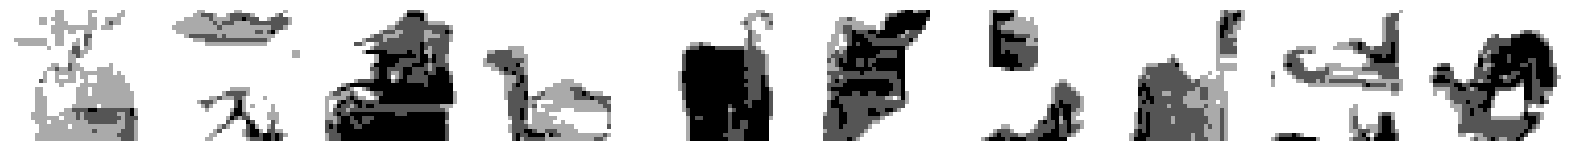

469/469 [==============================] - 57s 121ms/step - loss: 0.2127
Epoch 37/150
469/469 [==============================] - ETA: 0s - loss: 0.2123
Saved to ./temp/output/generated_img_036.png


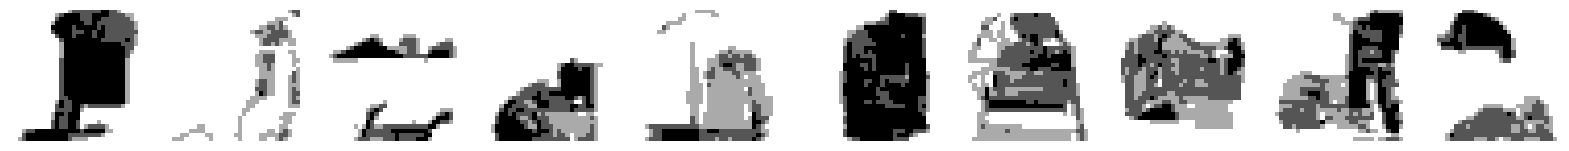

469/469 [==============================] - 57s 121ms/step - loss: 0.2123
Epoch 38/150
469/469 [==============================] - ETA: 0s - loss: 0.2123
Saved to ./temp/output/generated_img_037.png


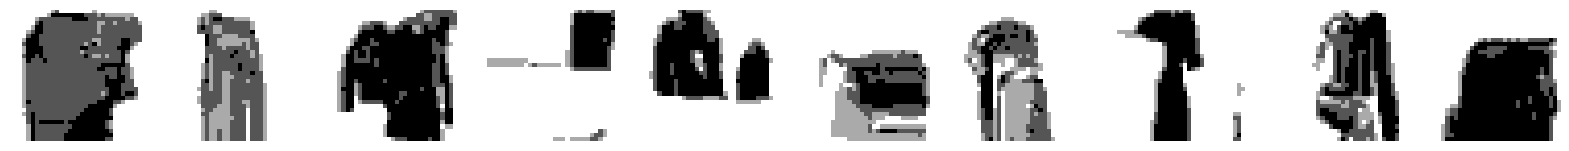

469/469 [==============================] - 56s 120ms/step - loss: 0.2123
Epoch 39/150
469/469 [==============================] - ETA: 0s - loss: 0.2121
Saved to ./temp/output/generated_img_038.png


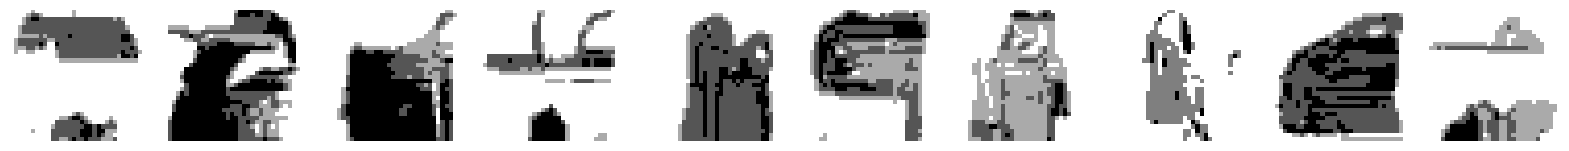

469/469 [==============================] - 57s 121ms/step - loss: 0.2121
Epoch 40/150
469/469 [==============================] - ETA: 0s - loss: 0.2120
Saved to ./temp/output/generated_img_039.png


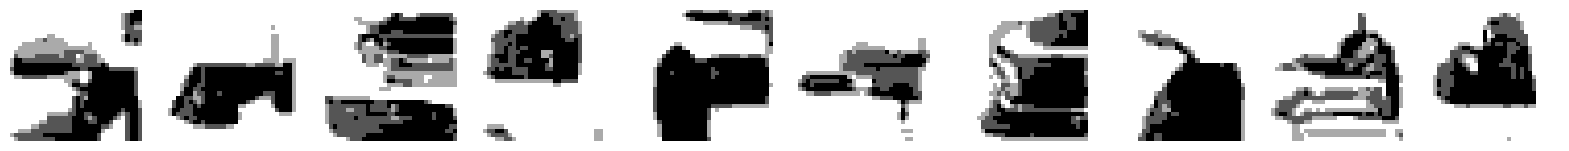

469/469 [==============================] - 57s 121ms/step - loss: 0.2120
Epoch 41/150
469/469 [==============================] - ETA: 0s - loss: 0.2117
Saved to ./temp/output/generated_img_040.png


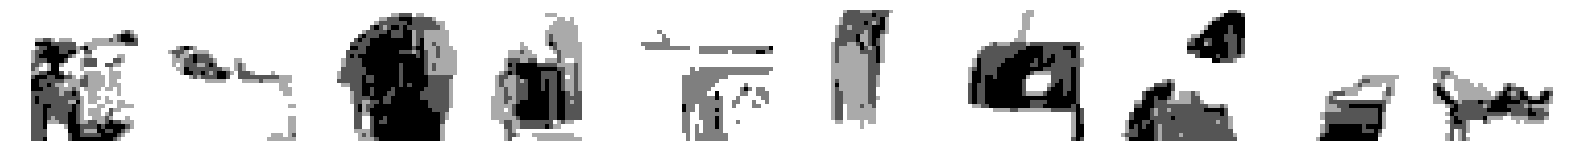

469/469 [==============================] - 57s 121ms/step - loss: 0.2117
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.2115
Saved to ./temp/output/generated_img_041.png


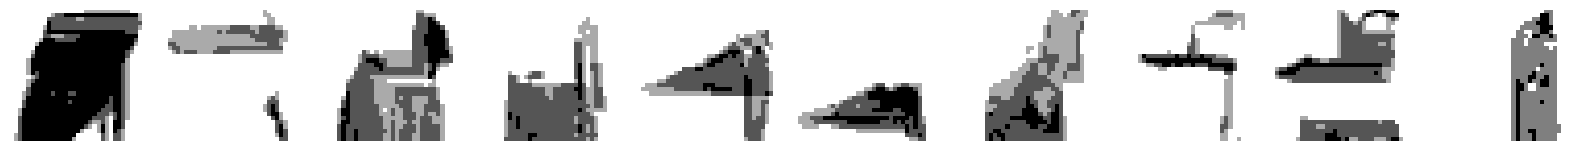

469/469 [==============================] - 57s 121ms/step - loss: 0.2115
Epoch 43/150
469/469 [==============================] - ETA: 0s - loss: 0.2114
Saved to ./temp/output/generated_img_042.png


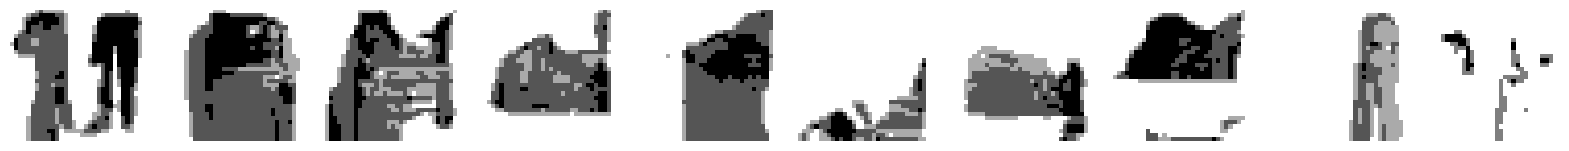

469/469 [==============================] - 57s 121ms/step - loss: 0.2114
Epoch 44/150
469/469 [==============================] - ETA: 0s - loss: 0.2112
Saved to ./temp/output/generated_img_043.png


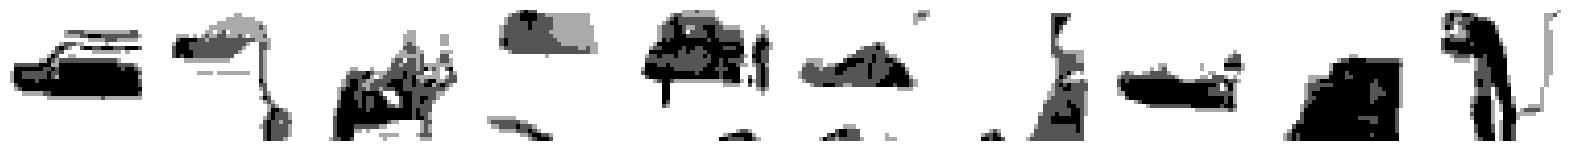

469/469 [==============================] - 56s 121ms/step - loss: 0.2112
Epoch 45/150
469/469 [==============================] - ETA: 0s - loss: 0.2111
Saved to ./temp/output/generated_img_044.png


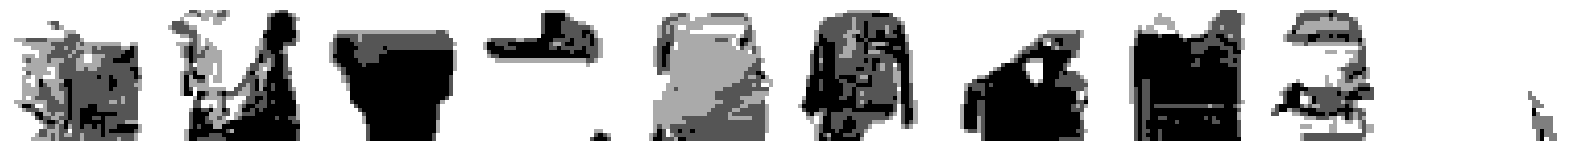

469/469 [==============================] - 57s 121ms/step - loss: 0.2111
Epoch 46/150
469/469 [==============================] - ETA: 0s - loss: 0.2109
Saved to ./temp/output/generated_img_045.png


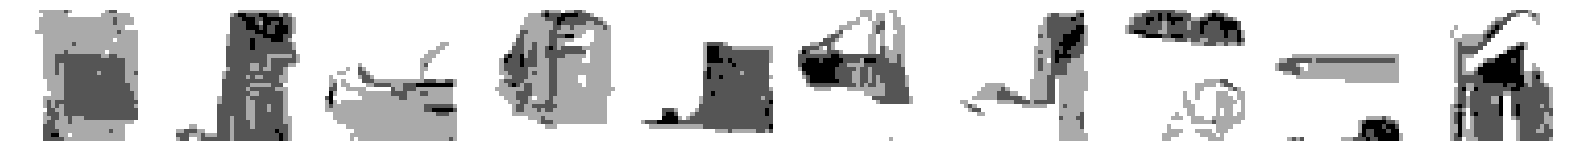

469/469 [==============================] - 56s 120ms/step - loss: 0.2109
Epoch 47/150
469/469 [==============================] - ETA: 0s - loss: 0.2108
Saved to ./temp/output/generated_img_046.png


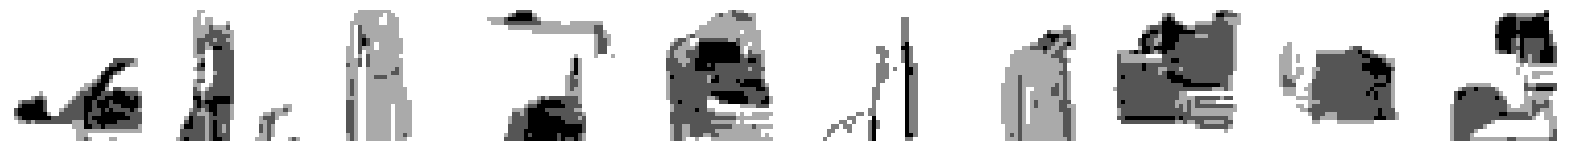

469/469 [==============================] - 56s 120ms/step - loss: 0.2108
Epoch 48/150
469/469 [==============================] - ETA: 0s - loss: 0.2106
Saved to ./temp/output/generated_img_047.png


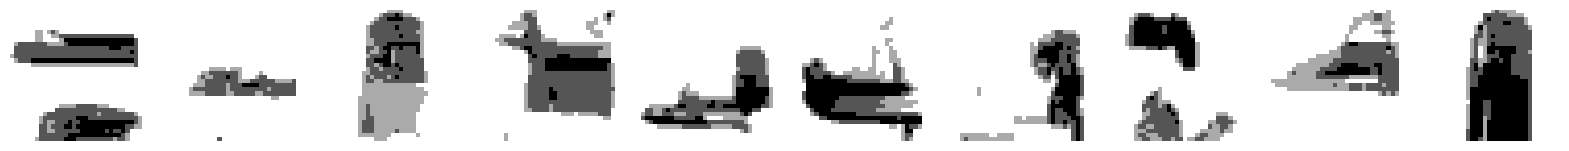

469/469 [==============================] - 57s 121ms/step - loss: 0.2106
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.2106
Saved to ./temp/output/generated_img_048.png


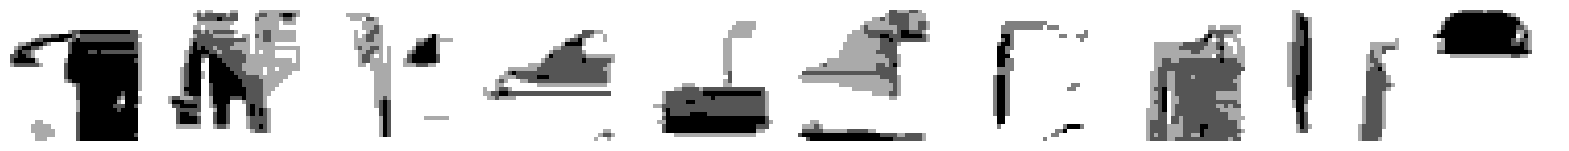

469/469 [==============================] - 57s 121ms/step - loss: 0.2106
Epoch 50/150
469/469 [==============================] - ETA: 0s - loss: 0.2103
Saved to ./temp/output/generated_img_049.png


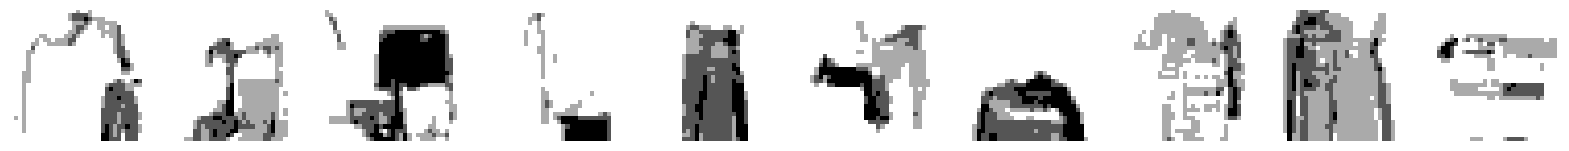

469/469 [==============================] - 57s 121ms/step - loss: 0.2103
Epoch 51/150
469/469 [==============================] - ETA: 0s - loss: 0.2102
Saved to ./temp/output/generated_img_050.png


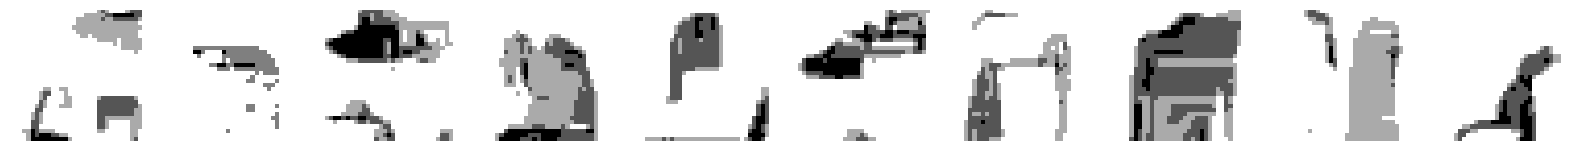

469/469 [==============================] - 57s 121ms/step - loss: 0.2102
Epoch 52/150
469/469 [==============================] - ETA: 0s - loss: 0.2102
Saved to ./temp/output/generated_img_051.png


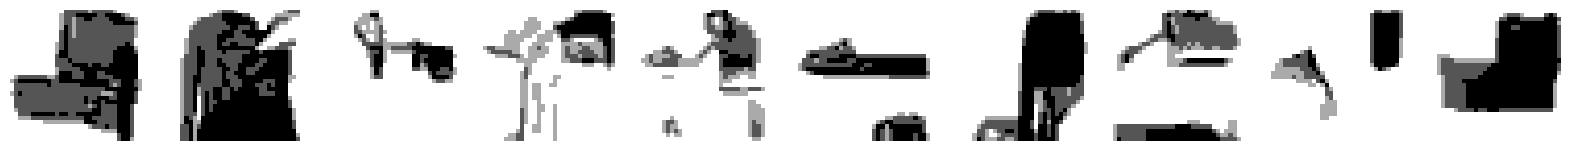

469/469 [==============================] - 56s 120ms/step - loss: 0.2102
Epoch 53/150
469/469 [==============================] - ETA: 0s - loss: 0.2100
Saved to ./temp/output/generated_img_052.png


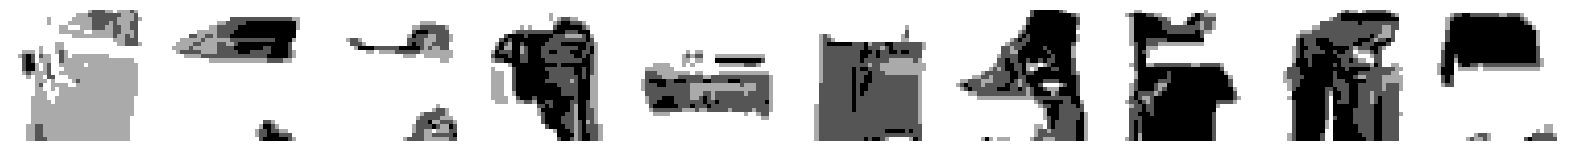

469/469 [==============================] - 57s 121ms/step - loss: 0.2100
Epoch 54/150
469/469 [==============================] - ETA: 0s - loss: 0.2098
Saved to ./temp/output/generated_img_053.png


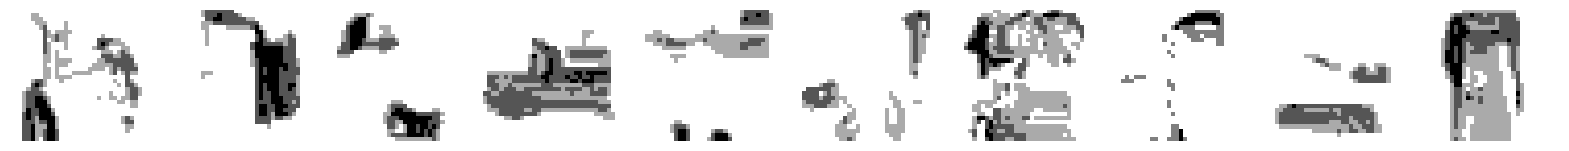

469/469 [==============================] - 57s 121ms/step - loss: 0.2098
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.2098
Saved to ./temp/output/generated_img_054.png


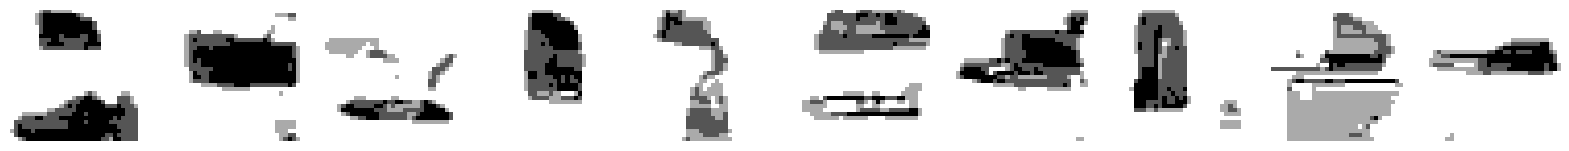

469/469 [==============================] - 57s 121ms/step - loss: 0.2098
Epoch 56/150
469/469 [==============================] - ETA: 0s - loss: 0.2096
Saved to ./temp/output/generated_img_055.png


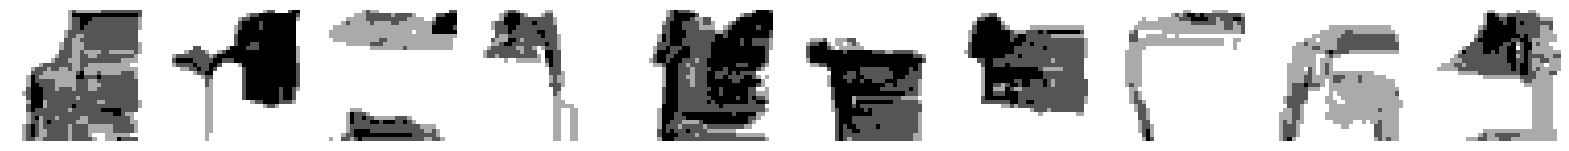

469/469 [==============================] - 57s 121ms/step - loss: 0.2096
Epoch 57/150
469/469 [==============================] - ETA: 0s - loss: 0.2095
Saved to ./temp/output/generated_img_056.png


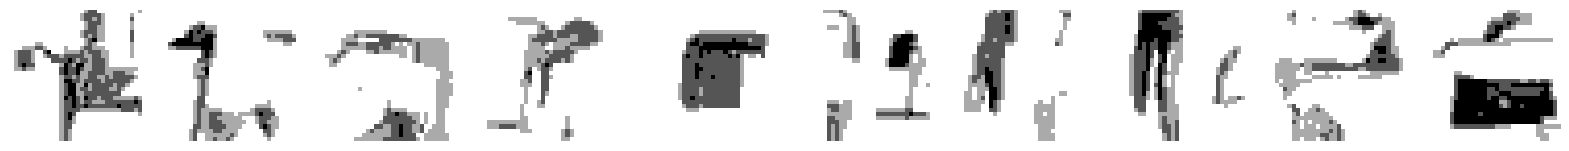

469/469 [==============================] - 56s 121ms/step - loss: 0.2095
Epoch 58/150
469/469 [==============================] - ETA: 0s - loss: 0.2095
Saved to ./temp/output/generated_img_057.png


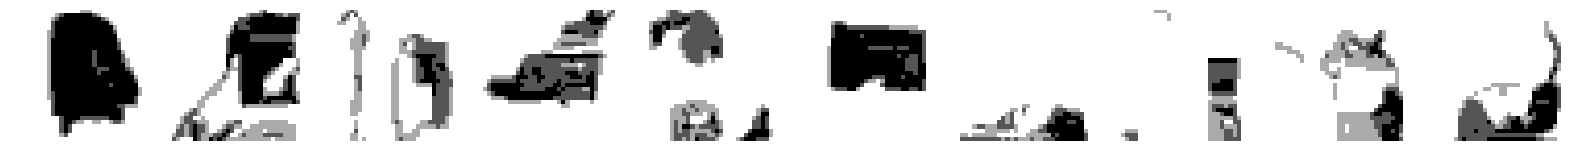

469/469 [==============================] - 56s 120ms/step - loss: 0.2095
Epoch 59/150
469/469 [==============================] - ETA: 0s - loss: 0.2093
Saved to ./temp/output/generated_img_058.png


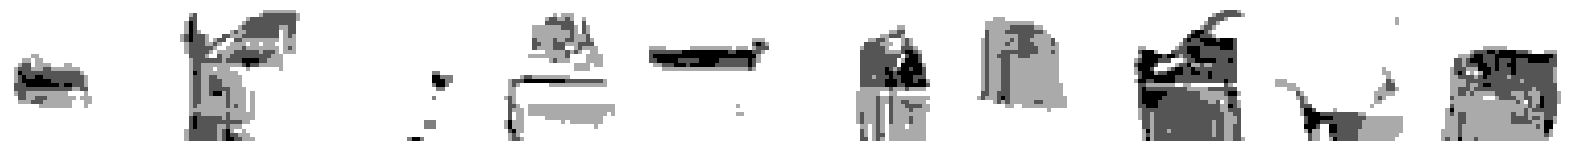

469/469 [==============================] - 56s 120ms/step - loss: 0.2093
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.2093
Saved to ./temp/output/generated_img_059.png


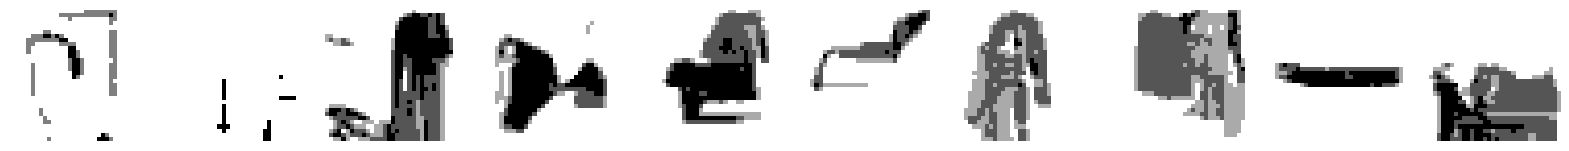

469/469 [==============================] - 56s 120ms/step - loss: 0.2093
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.2091
Saved to ./temp/output/generated_img_060.png


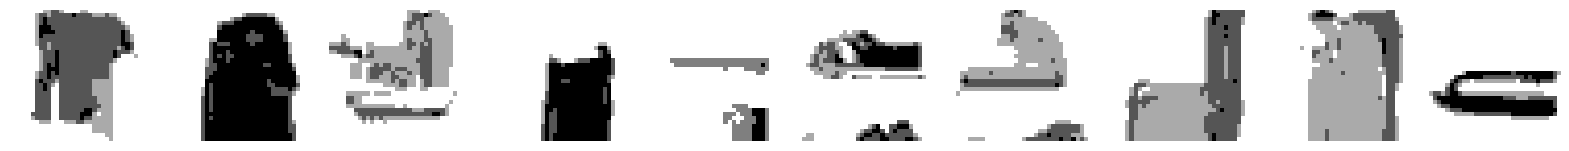

469/469 [==============================] - 56s 120ms/step - loss: 0.2091
Epoch 62/150
469/469 [==============================] - ETA: 0s - loss: 0.2089
Saved to ./temp/output/generated_img_061.png


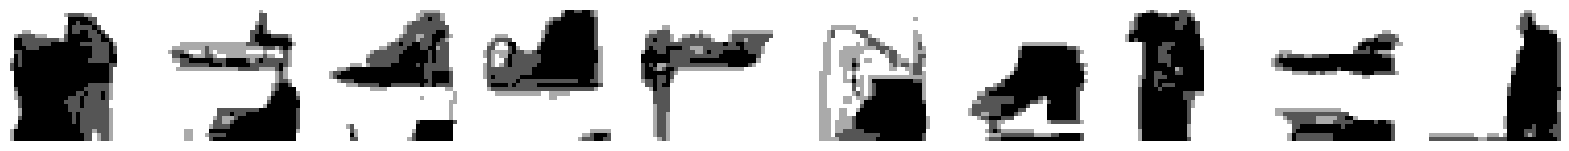

469/469 [==============================] - 56s 120ms/step - loss: 0.2089
Epoch 63/150
469/469 [==============================] - ETA: 0s - loss: 0.2089
Saved to ./temp/output/generated_img_062.png


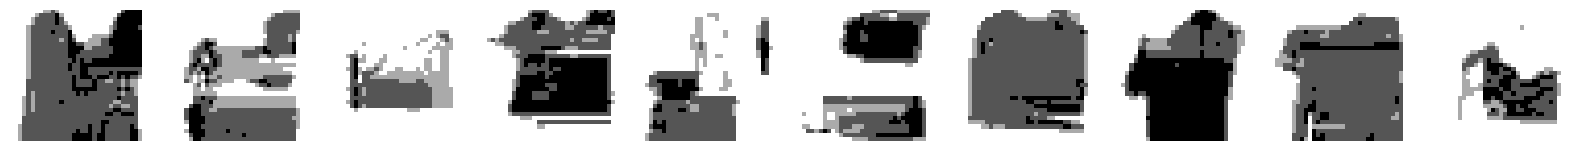

469/469 [==============================] - 56s 120ms/step - loss: 0.2089
Epoch 64/150
469/469 [==============================] - ETA: 0s - loss: 0.2088
Saved to ./temp/output/generated_img_063.png


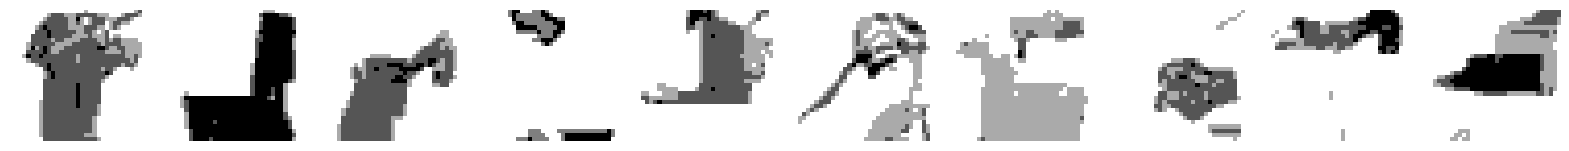

469/469 [==============================] - 57s 121ms/step - loss: 0.2088
Epoch 65/150
469/469 [==============================] - ETA: 0s - loss: 0.2088
Saved to ./temp/output/generated_img_064.png


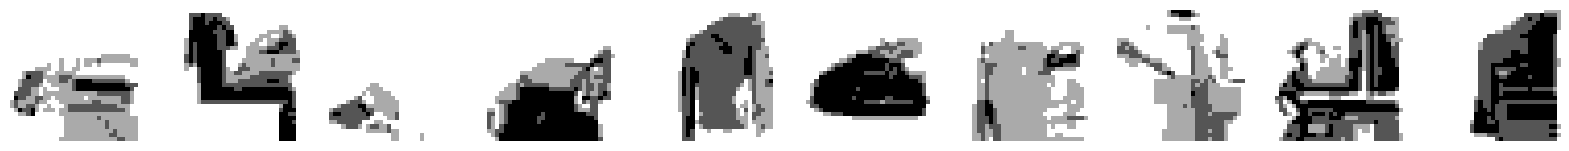

469/469 [==============================] - 56s 120ms/step - loss: 0.2088
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.2085
Saved to ./temp/output/generated_img_065.png


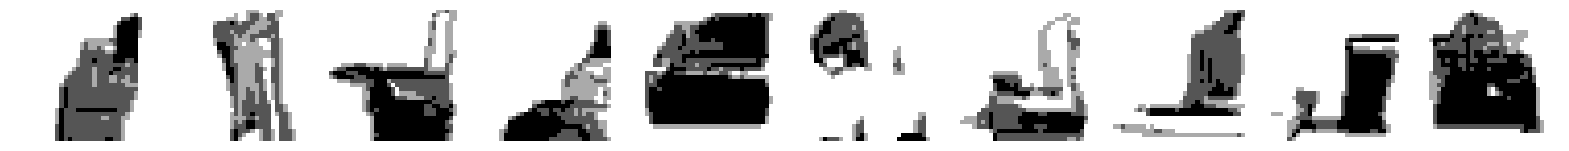

469/469 [==============================] - 57s 121ms/step - loss: 0.2085
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.2085
Saved to ./temp/output/generated_img_066.png


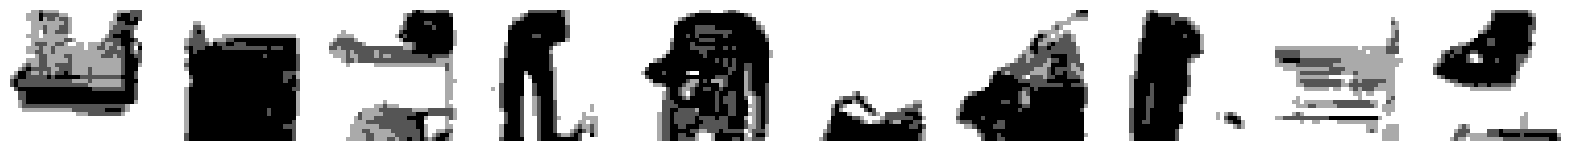

469/469 [==============================] - 57s 121ms/step - loss: 0.2085
Epoch 68/150
469/469 [==============================] - ETA: 0s - loss: 0.2085
Saved to ./temp/output/generated_img_067.png


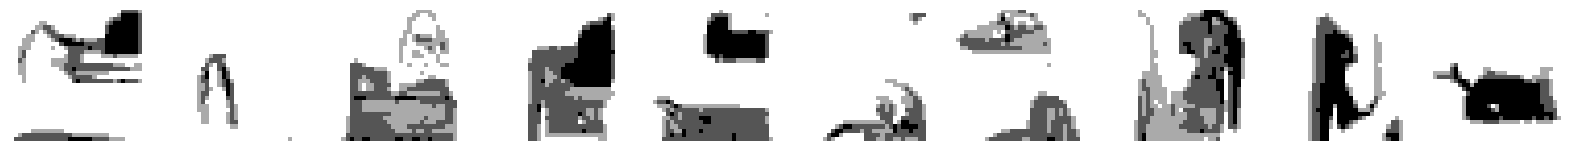

469/469 [==============================] - 57s 121ms/step - loss: 0.2085
Epoch 69/150
469/469 [==============================] - ETA: 0s - loss: 0.2083
Saved to ./temp/output/generated_img_068.png


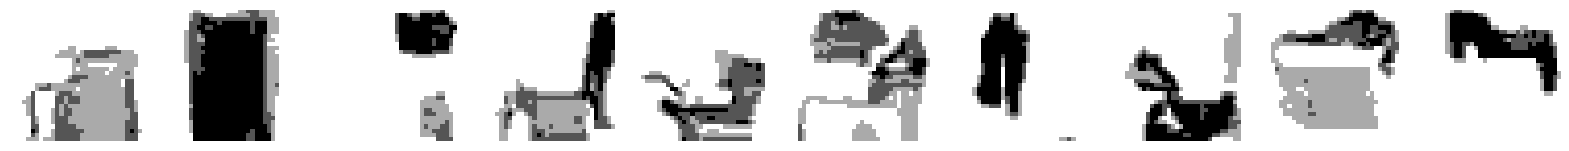

469/469 [==============================] - 57s 121ms/step - loss: 0.2083
Epoch 70/150
469/469 [==============================] - ETA: 0s - loss: 0.2082
Saved to ./temp/output/generated_img_069.png


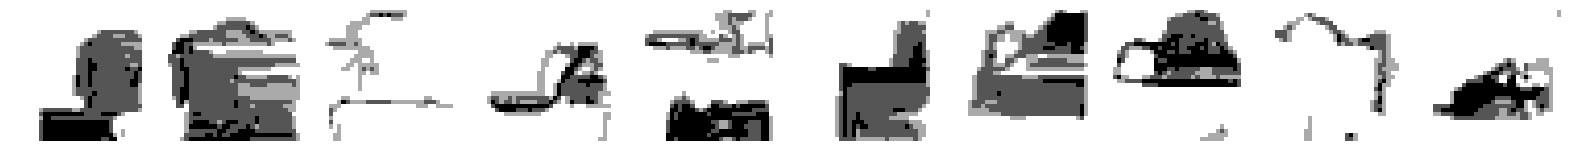

469/469 [==============================] - 57s 121ms/step - loss: 0.2082
Epoch 71/150
469/469 [==============================] - ETA: 0s - loss: 0.2082
Saved to ./temp/output/generated_img_070.png


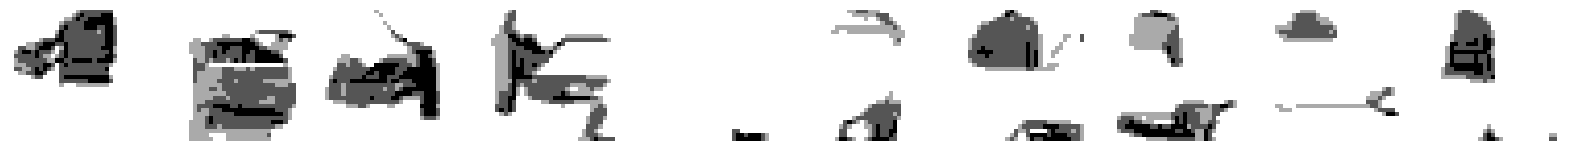

469/469 [==============================] - 56s 120ms/step - loss: 0.2082
Epoch 72/150
469/469 [==============================] - ETA: 0s - loss: 0.2081
Saved to ./temp/output/generated_img_071.png


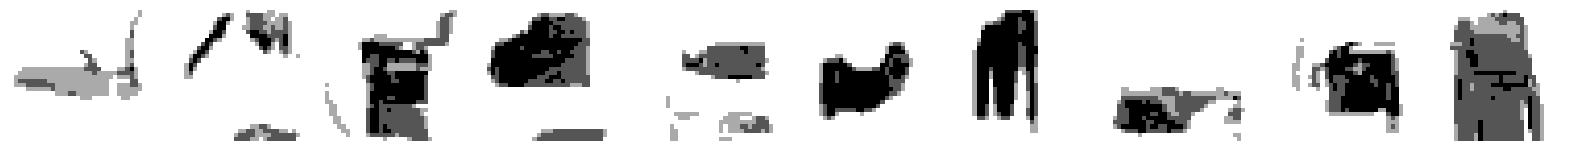

469/469 [==============================] - 57s 121ms/step - loss: 0.2081
Epoch 73/150
469/469 [==============================] - ETA: 0s - loss: 0.2081
Saved to ./temp/output/generated_img_072.png


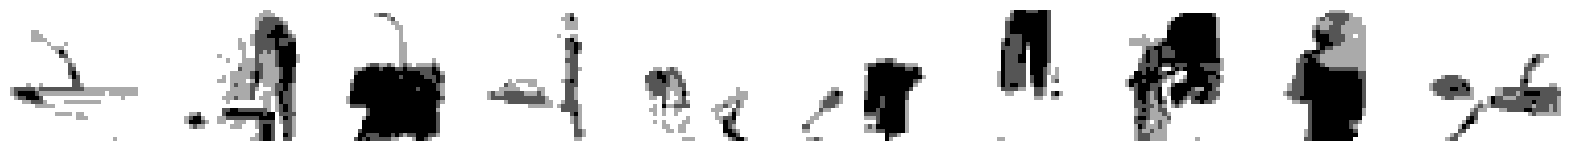

469/469 [==============================] - 56s 121ms/step - loss: 0.2081
Epoch 74/150
469/469 [==============================] - ETA: 0s - loss: 0.2079
Saved to ./temp/output/generated_img_073.png


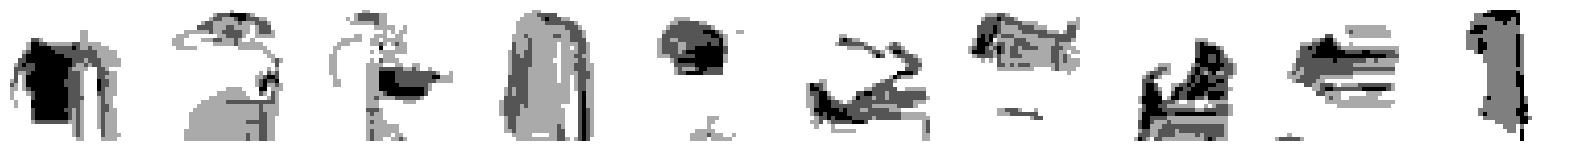

469/469 [==============================] - 56s 120ms/step - loss: 0.2079
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.2078
Saved to ./temp/output/generated_img_074.png


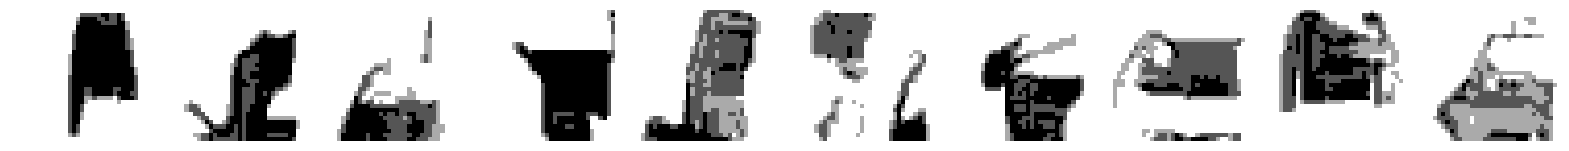

469/469 [==============================] - 56s 120ms/step - loss: 0.2078
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.2078
Saved to ./temp/output/generated_img_075.png


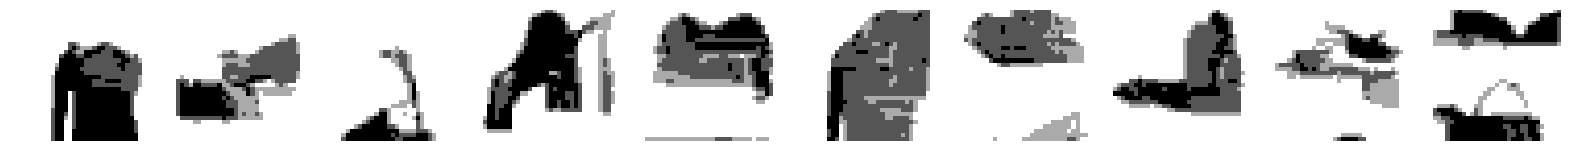

469/469 [==============================] - 57s 121ms/step - loss: 0.2078
Epoch 77/150
469/469 [==============================] - ETA: 0s - loss: 0.2078
Saved to ./temp/output/generated_img_076.png


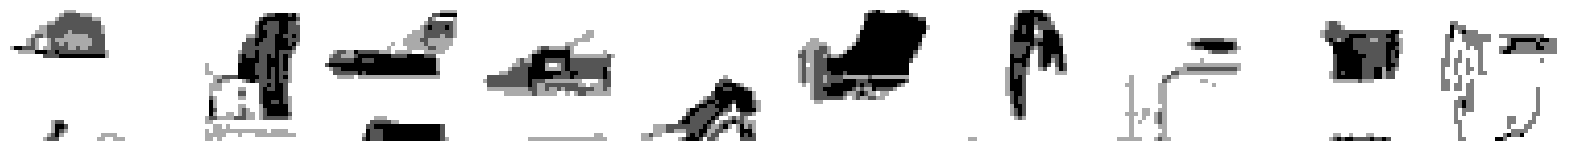

469/469 [==============================] - 57s 121ms/step - loss: 0.2078
Epoch 78/150
469/469 [==============================] - ETA: 0s - loss: 0.2076
Saved to ./temp/output/generated_img_077.png


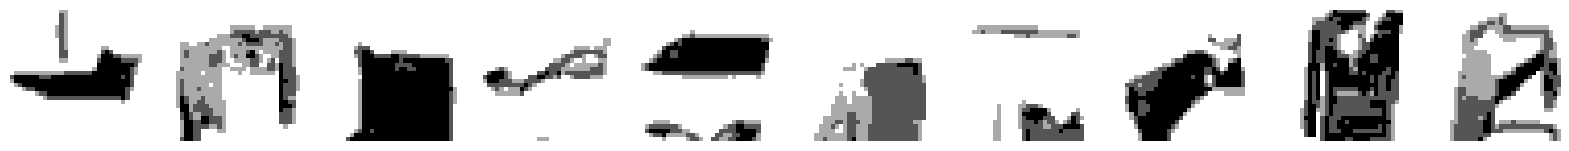

469/469 [==============================] - 56s 120ms/step - loss: 0.2076
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.2075
Saved to ./temp/output/generated_img_078.png


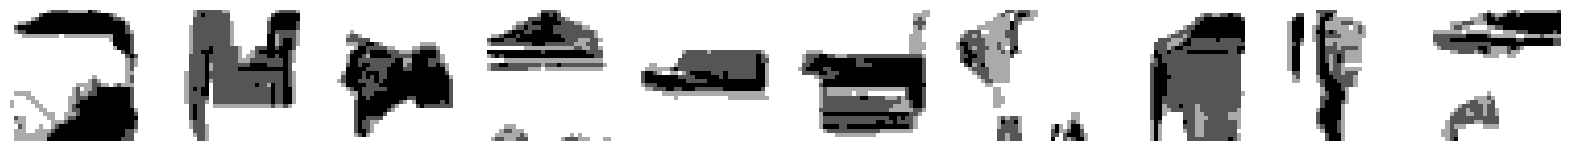

469/469 [==============================] - 56s 120ms/step - loss: 0.2075
Epoch 80/150
469/469 [==============================] - ETA: 0s - loss: 0.2075
Saved to ./temp/output/generated_img_079.png


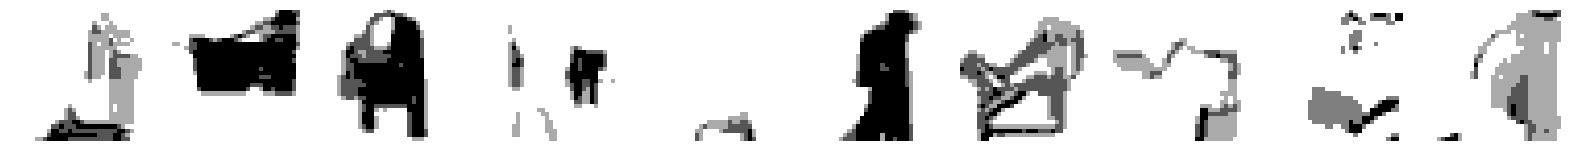

469/469 [==============================] - 57s 121ms/step - loss: 0.2075
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.2075
Saved to ./temp/output/generated_img_080.png


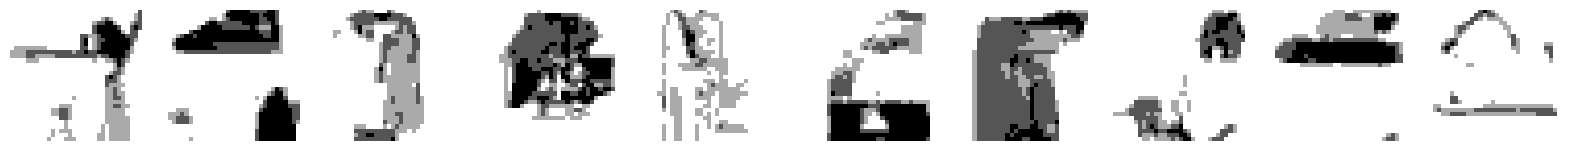

469/469 [==============================] - 57s 121ms/step - loss: 0.2075
Epoch 82/150
469/469 [==============================] - ETA: 0s - loss: 0.2073
Saved to ./temp/output/generated_img_081.png


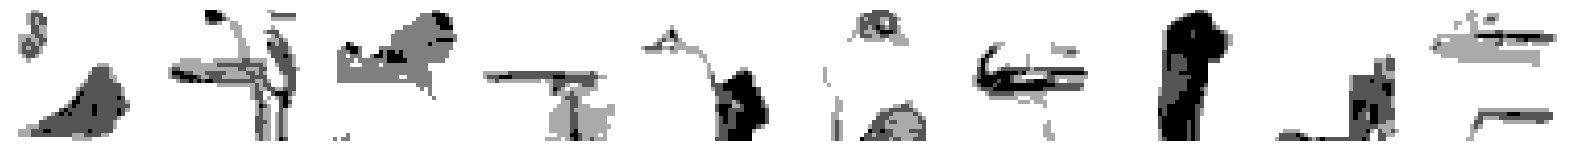

469/469 [==============================] - 57s 121ms/step - loss: 0.2073
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.2073
Saved to ./temp/output/generated_img_082.png


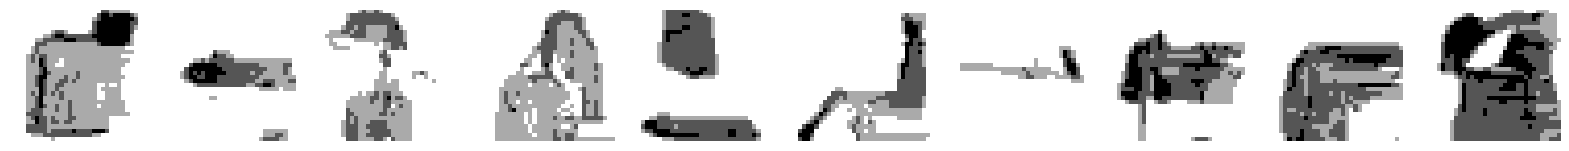

469/469 [==============================] - 57s 121ms/step - loss: 0.2073
Epoch 84/150
469/469 [==============================] - ETA: 0s - loss: 0.2073
Saved to ./temp/output/generated_img_083.png


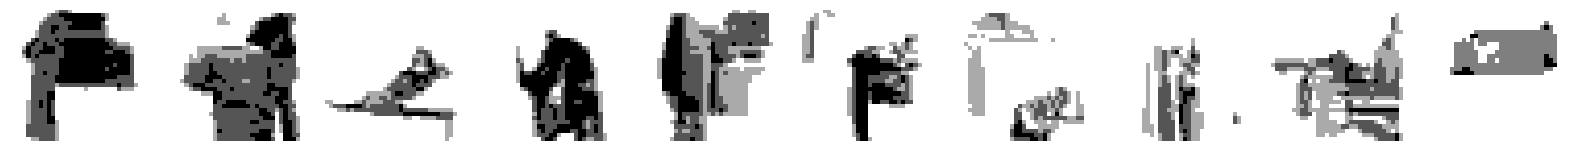

469/469 [==============================] - 57s 121ms/step - loss: 0.2073
Epoch 85/150
469/469 [==============================] - ETA: 0s - loss: 0.2072
Saved to ./temp/output/generated_img_084.png


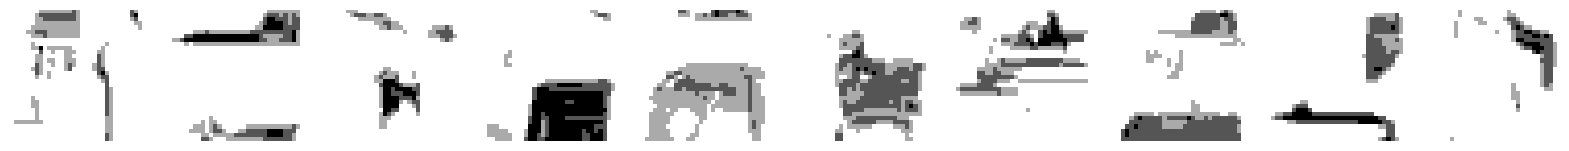

469/469 [==============================] - 56s 120ms/step - loss: 0.2072
Epoch 86/150
469/469 [==============================] - ETA: 0s - loss: 0.2071
Saved to ./temp/output/generated_img_085.png


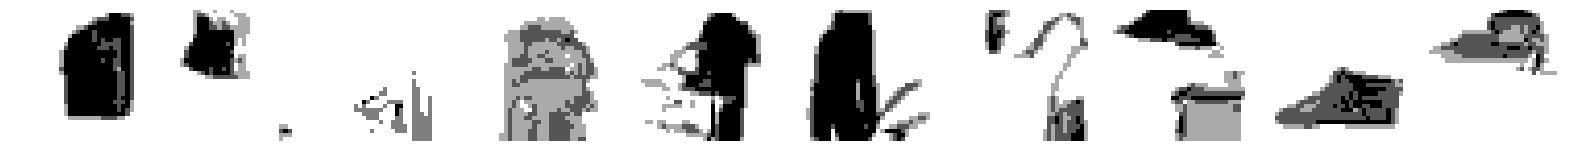

469/469 [==============================] - 57s 121ms/step - loss: 0.2071
Epoch 87/150
469/469 [==============================] - ETA: 0s - loss: 0.2070
Saved to ./temp/output/generated_img_086.png


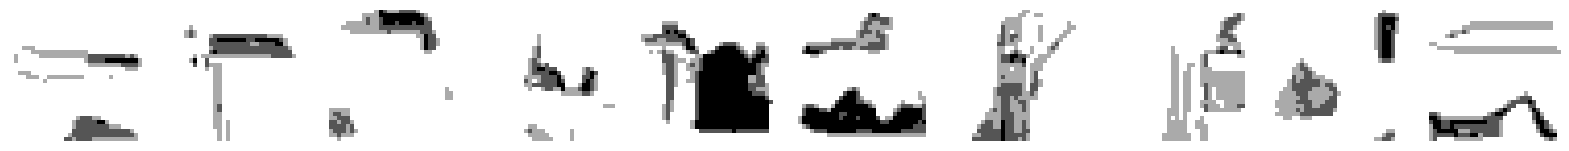

469/469 [==============================] - 57s 121ms/step - loss: 0.2070
Epoch 88/150
469/469 [==============================] - ETA: 0s - loss: 0.2070
Saved to ./temp/output/generated_img_087.png


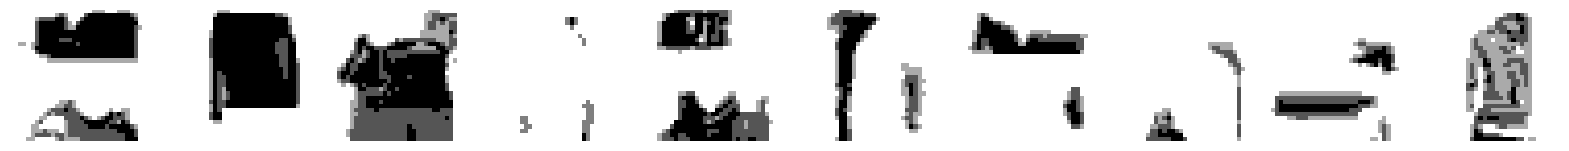

469/469 [==============================] - 57s 121ms/step - loss: 0.2070
Epoch 89/150
469/469 [==============================] - ETA: 0s - loss: 0.2069
Saved to ./temp/output/generated_img_088.png


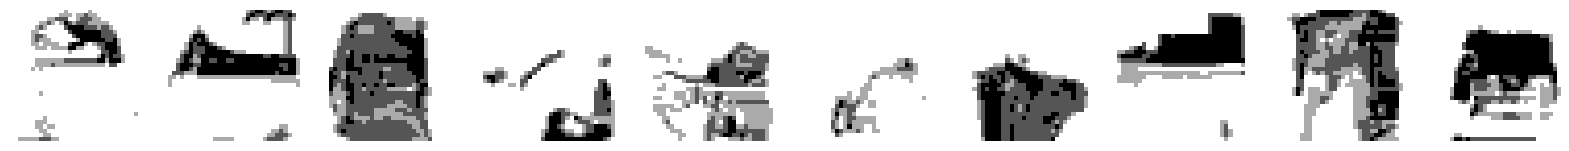

469/469 [==============================] - 56s 121ms/step - loss: 0.2069
Epoch 90/150
469/469 [==============================] - ETA: 0s - loss: 0.2069
Saved to ./temp/output/generated_img_089.png


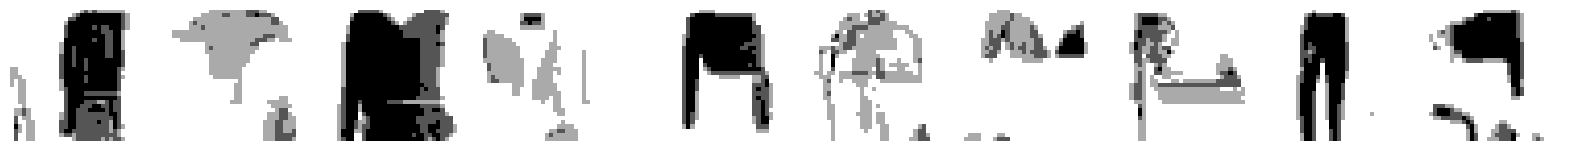

469/469 [==============================] - 56s 120ms/step - loss: 0.2069
Epoch 91/150
469/469 [==============================] - ETA: 0s - loss: 0.2068
Saved to ./temp/output/generated_img_090.png


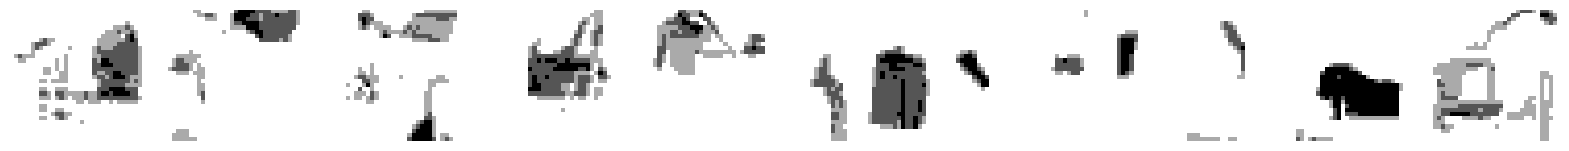

469/469 [==============================] - 57s 121ms/step - loss: 0.2068
Epoch 92/150
469/469 [==============================] - ETA: 0s - loss: 0.2067
Saved to ./temp/output/generated_img_091.png


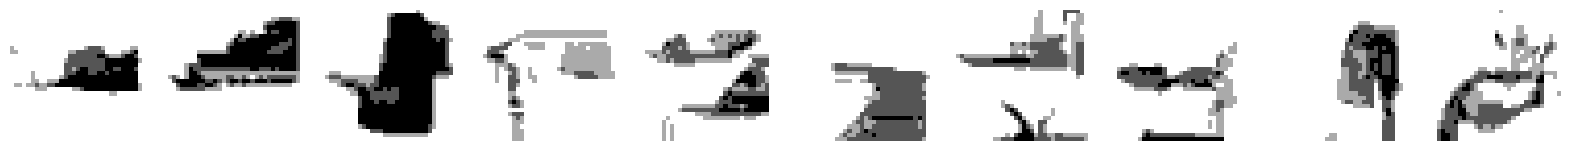

469/469 [==============================] - 69s 146ms/step - loss: 0.2067
Epoch 93/150
469/469 [==============================] - ETA: 0s - loss: 0.2067
Saved to ./temp/output/generated_img_092.png


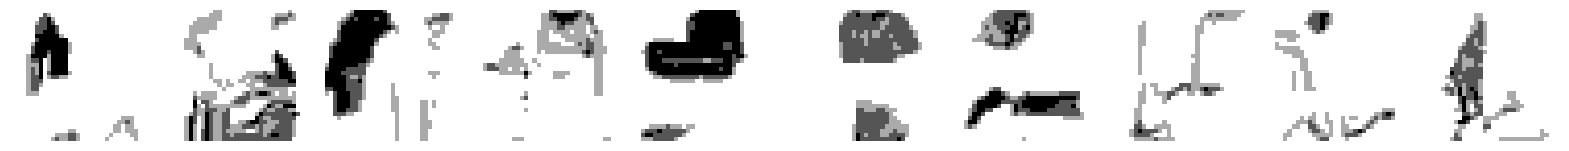

469/469 [==============================] - 66s 140ms/step - loss: 0.2067
Epoch 94/150
469/469 [==============================] - ETA: 0s - loss: 0.2067
Saved to ./temp/output/generated_img_093.png


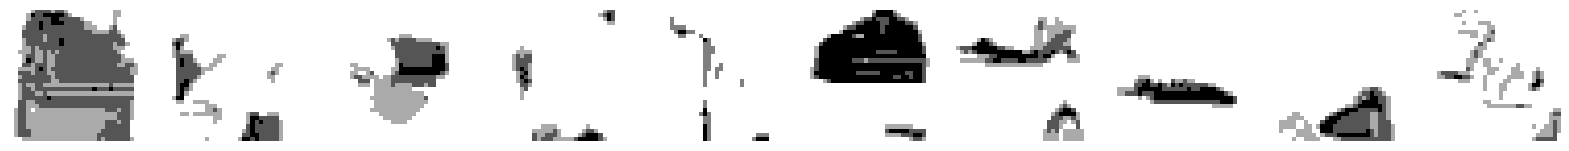

469/469 [==============================] - 726s 2s/step - loss: 0.2067
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.2066
Saved to ./temp/output/generated_img_094.png


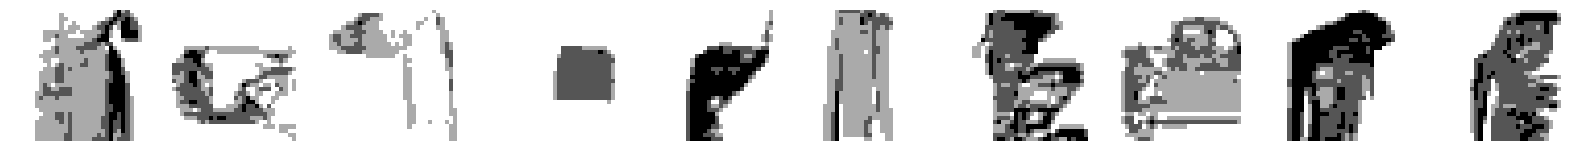

469/469 [==============================] - 56s 119ms/step - loss: 0.2066
Epoch 96/150
469/469 [==============================] - ETA: 0s - loss: 0.2064
Saved to ./temp/output/generated_img_095.png


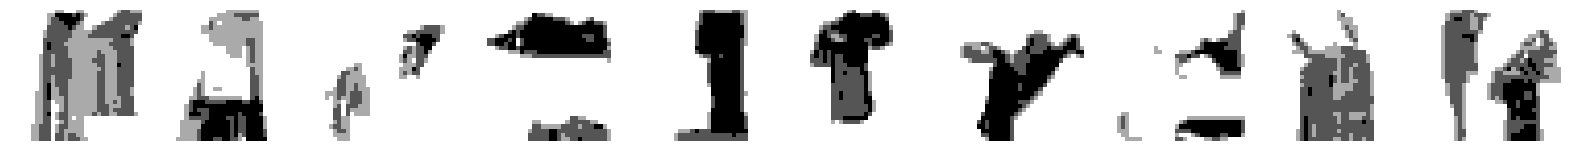

469/469 [==============================] - 123s 263ms/step - loss: 0.2064
Epoch 97/150
469/469 [==============================] - ETA: 0s - loss: 0.2064
Saved to ./temp/output/generated_img_096.png


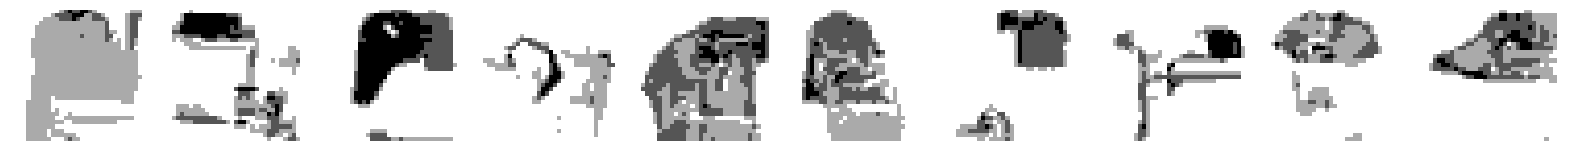

469/469 [==============================] - 80s 171ms/step - loss: 0.2064
Epoch 98/150
469/469 [==============================] - ETA: 0s - loss: 0.2064
Saved to ./temp/output/generated_img_097.png


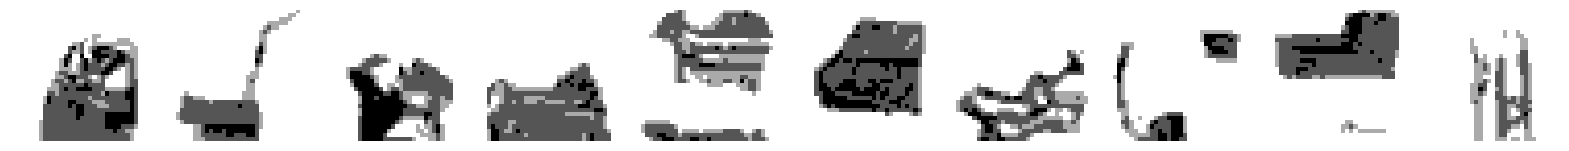

469/469 [==============================] - 74s 157ms/step - loss: 0.2064
Epoch 99/150
469/469 [==============================] - ETA: 0s - loss: 0.2063
Saved to ./temp/output/generated_img_098.png


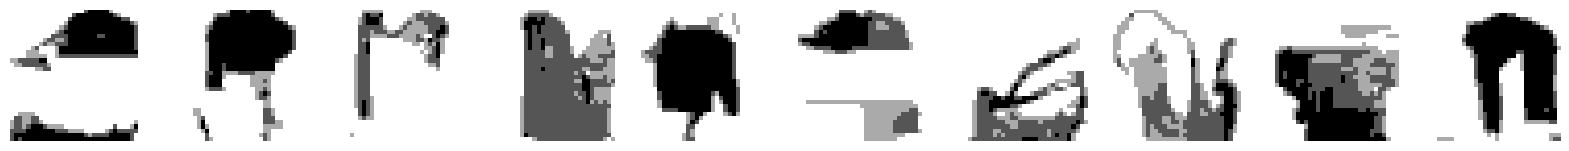

469/469 [==============================] - 69s 147ms/step - loss: 0.2063
Epoch 100/150
469/469 [==============================] - ETA: 0s - loss: 0.2063
Saved to ./temp/output/generated_img_099.png


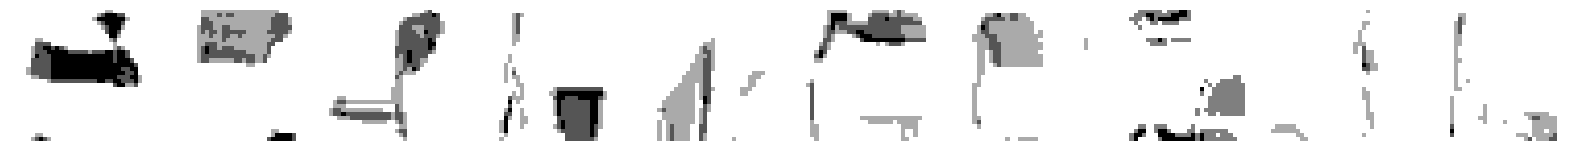

469/469 [==============================] - 70s 149ms/step - loss: 0.2063
Epoch 101/150
469/469 [==============================] - ETA: 0s - loss: 0.2063
Saved to ./temp/output/generated_img_100.png


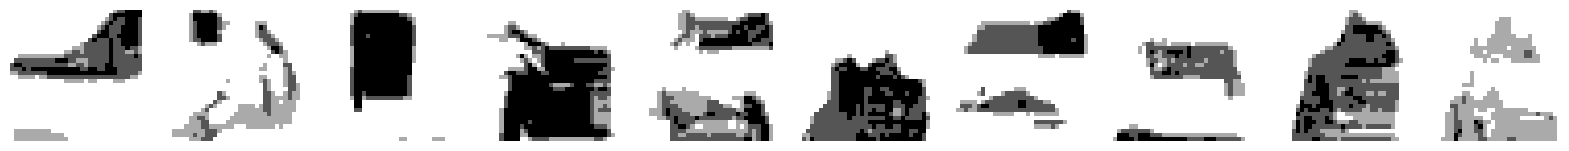

469/469 [==============================] - 89s 191ms/step - loss: 0.2063
Epoch 102/150
469/469 [==============================] - ETA: 0s - loss: 0.2062
Saved to ./temp/output/generated_img_101.png


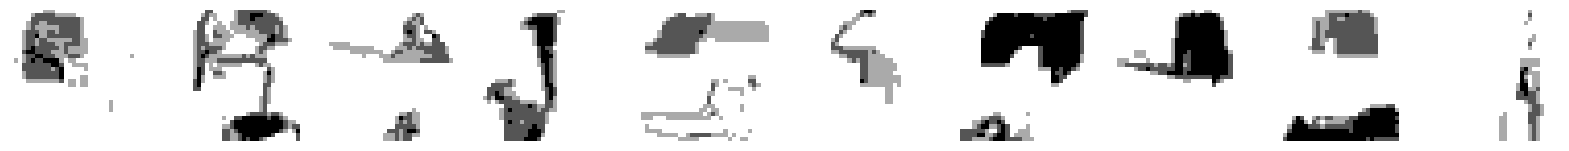

469/469 [==============================] - 75s 159ms/step - loss: 0.2062
Epoch 103/150
469/469 [==============================] - ETA: 0s - loss: 0.2062
Saved to ./temp/output/generated_img_102.png


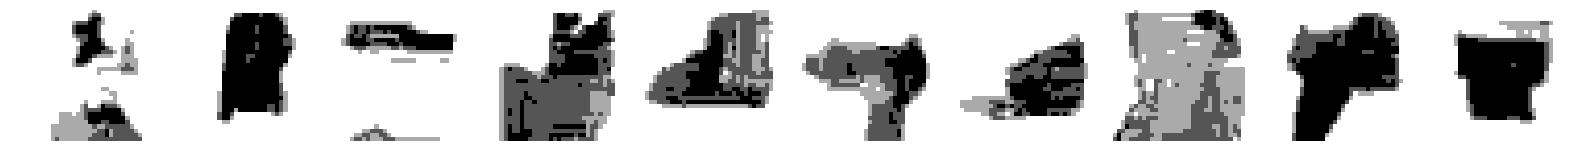

469/469 [==============================] - 580s 1s/step - loss: 0.2062
Epoch 104/150
469/469 [==============================] - ETA: 0s - loss: 0.2061
Saved to ./temp/output/generated_img_103.png


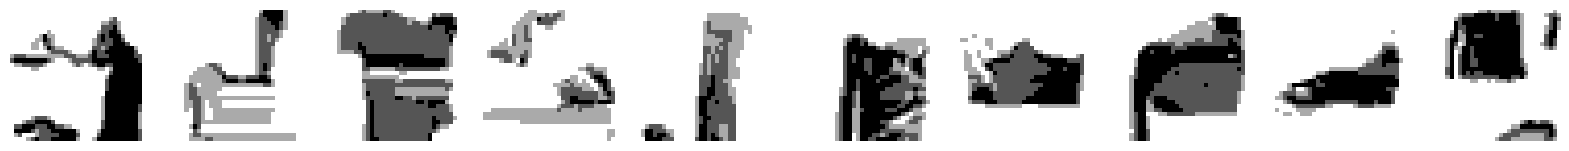

469/469 [==============================] - 199s 426ms/step - loss: 0.2061
Epoch 105/150
469/469 [==============================] - ETA: 0s - loss: 0.2061
Saved to ./temp/output/generated_img_104.png


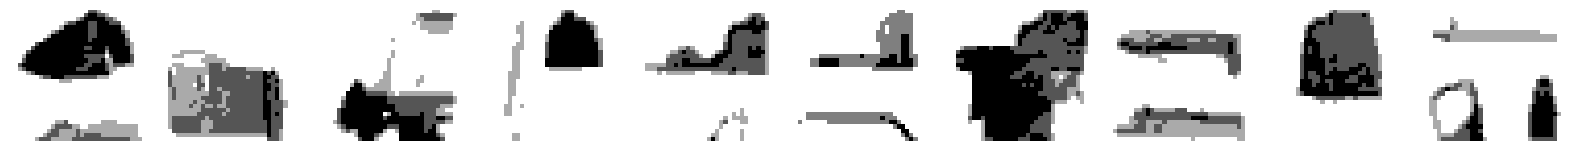

469/469 [==============================] - 87s 187ms/step - loss: 0.2061
Epoch 106/150
469/469 [==============================] - ETA: 0s - loss: 0.2060
Saved to ./temp/output/generated_img_105.png


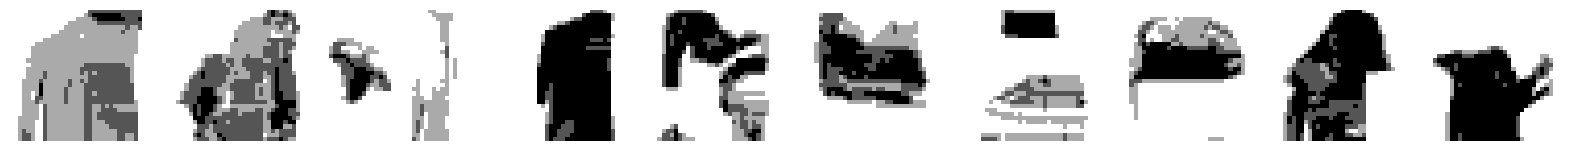

469/469 [==============================] - 75s 159ms/step - loss: 0.2060
Epoch 107/150
469/469 [==============================] - ETA: 0s - loss: 0.2059
Saved to ./temp/output/generated_img_106.png


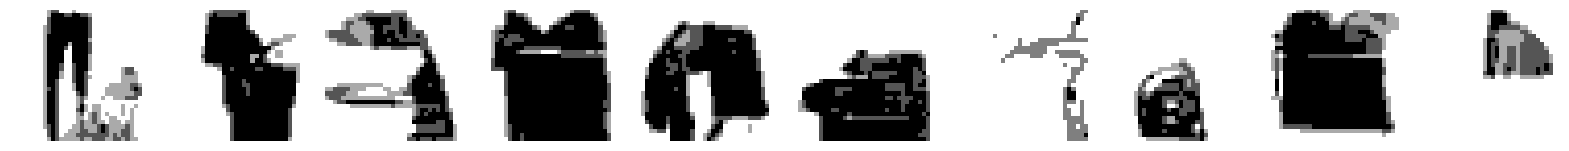

469/469 [==============================] - 1014s 2s/step - loss: 0.2059
Epoch 108/150
469/469 [==============================] - ETA: 0s - loss: 0.2060
Saved to ./temp/output/generated_img_107.png


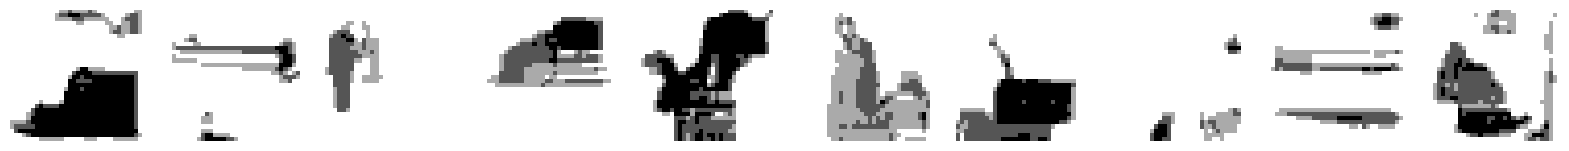

469/469 [==============================] - 55s 118ms/step - loss: 0.2060
Epoch 109/150
469/469 [==============================] - ETA: 0s - loss: 0.2059
Saved to ./temp/output/generated_img_108.png


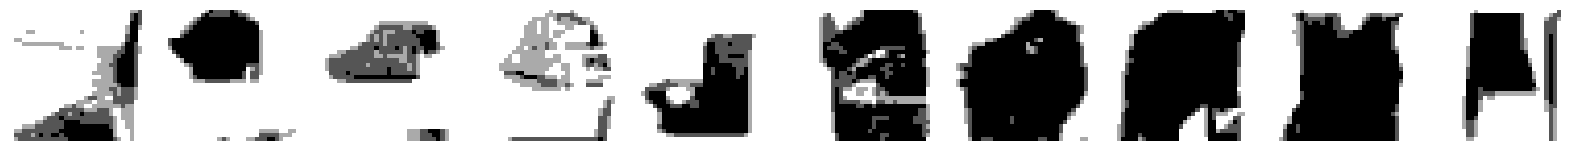

469/469 [==============================] - 512s 1s/step - loss: 0.2059
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.2058
Saved to ./temp/output/generated_img_109.png


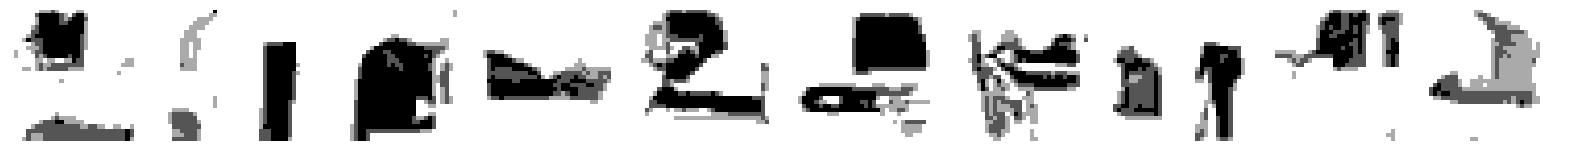

469/469 [==============================] - 959s 2s/step - loss: 0.2058
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.2058
Saved to ./temp/output/generated_img_110.png


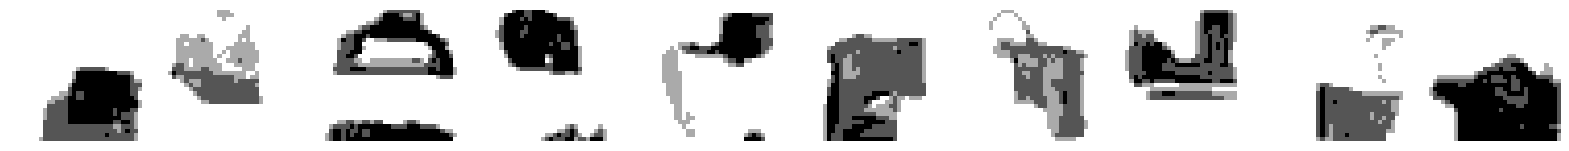

469/469 [==============================] - 55s 118ms/step - loss: 0.2058
Epoch 112/150
469/469 [==============================] - ETA: 0s - loss: 0.2058
Saved to ./temp/output/generated_img_111.png


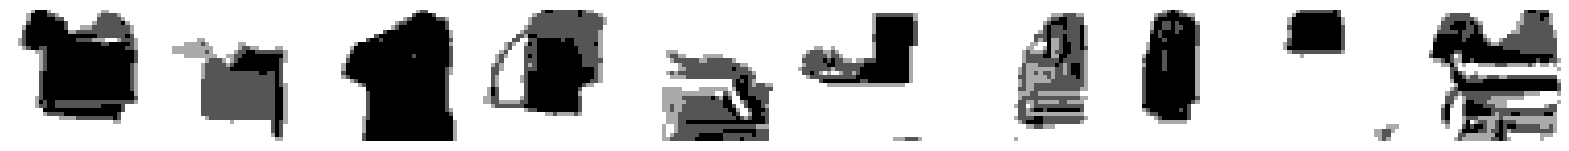

469/469 [==============================] - 236s 503ms/step - loss: 0.2058
Epoch 113/150
469/469 [==============================] - ETA: 0s - loss: 0.2057
Saved to ./temp/output/generated_img_112.png


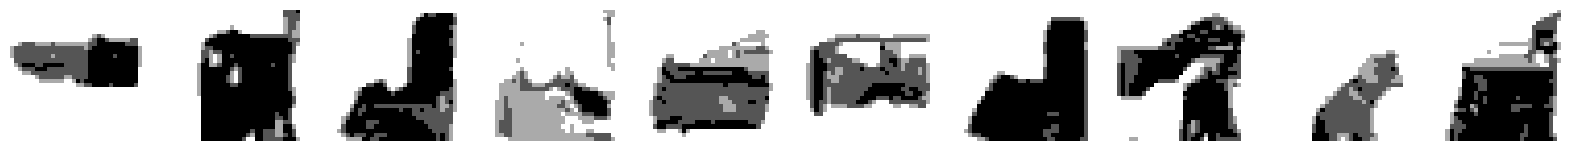

469/469 [==============================] - 197s 422ms/step - loss: 0.2057
Epoch 114/150
469/469 [==============================] - ETA: 0s - loss: 0.2056
Saved to ./temp/output/generated_img_113.png


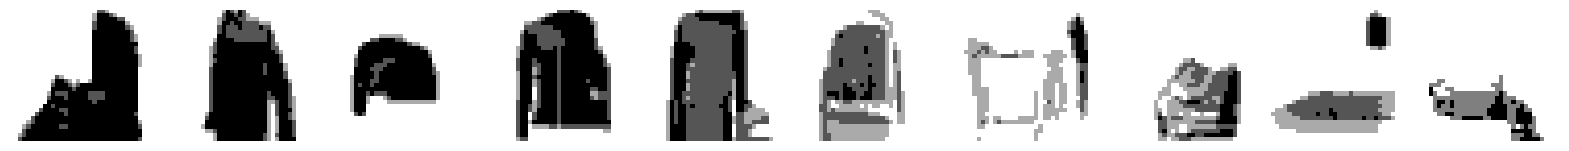

469/469 [==============================] - 58s 125ms/step - loss: 0.2056
Epoch 115/150
469/469 [==============================] - ETA: 0s - loss: 0.2056
Saved to ./temp/output/generated_img_114.png


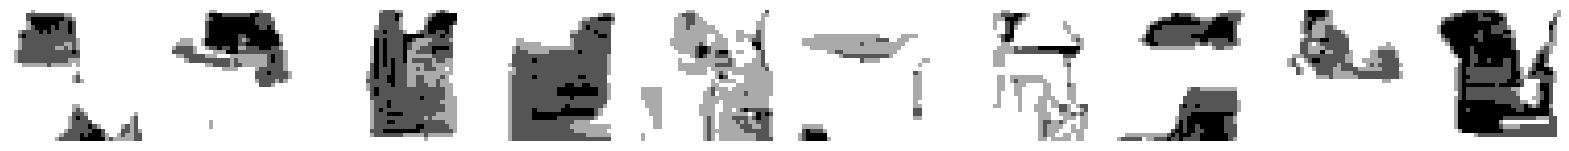

469/469 [==============================] - 57s 122ms/step - loss: 0.2056
Epoch 116/150
469/469 [==============================] - ETA: 0s - loss: 0.2056
Saved to ./temp/output/generated_img_115.png


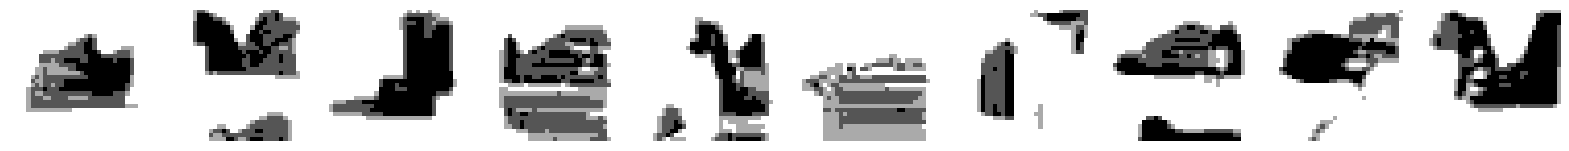

469/469 [==============================] - 57s 122ms/step - loss: 0.2056
Epoch 117/150
469/469 [==============================] - ETA: 0s - loss: 0.2055
Saved to ./temp/output/generated_img_116.png


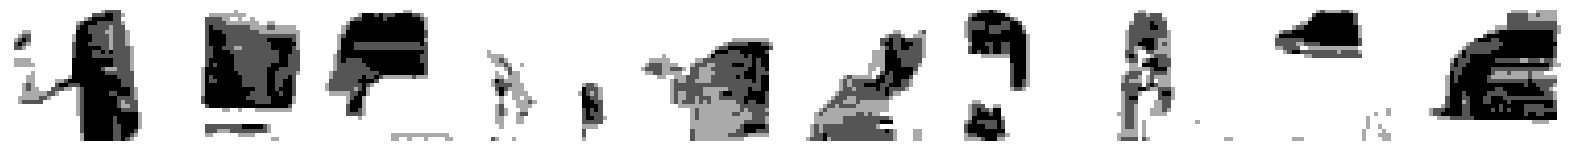

469/469 [==============================] - 57s 122ms/step - loss: 0.2055
Epoch 118/150
469/469 [==============================] - ETA: 0s - loss: 0.2055
Saved to ./temp/output/generated_img_117.png


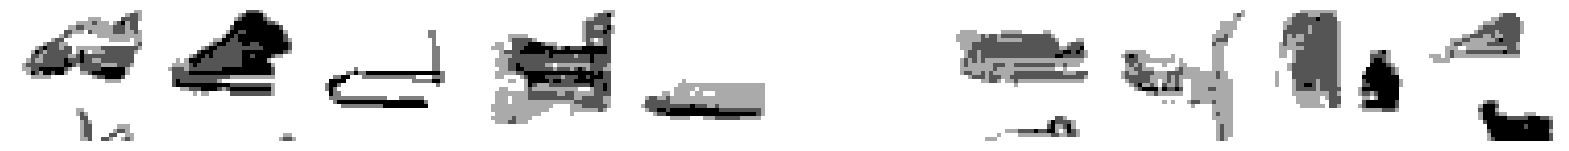

469/469 [==============================] - 72s 155ms/step - loss: 0.2055
Epoch 119/150
469/469 [==============================] - ETA: 0s - loss: 0.2055
Saved to ./temp/output/generated_img_118.png


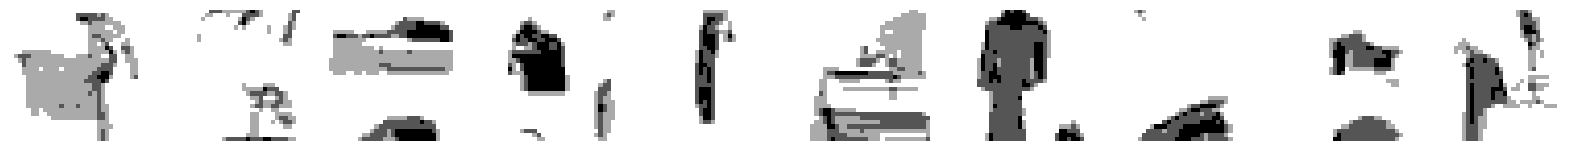

469/469 [==============================] - 63s 135ms/step - loss: 0.2055
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.2054
Saved to ./temp/output/generated_img_119.png


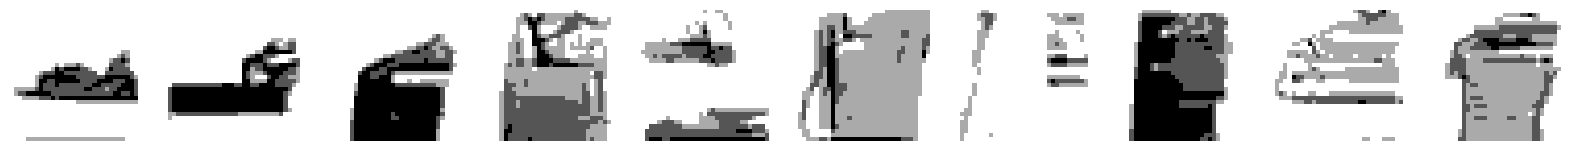

469/469 [==============================] - 59s 127ms/step - loss: 0.2054
Epoch 121/150
469/469 [==============================] - ETA: 0s - loss: 0.2054
Saved to ./temp/output/generated_img_120.png


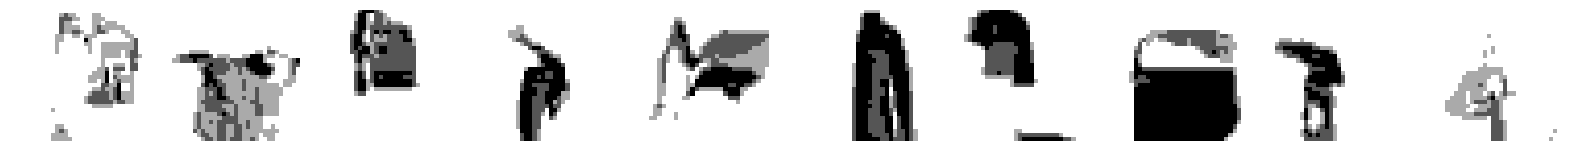

469/469 [==============================] - 58s 123ms/step - loss: 0.2054
Epoch 122/150
469/469 [==============================] - ETA: 0s - loss: 0.2053
Saved to ./temp/output/generated_img_121.png


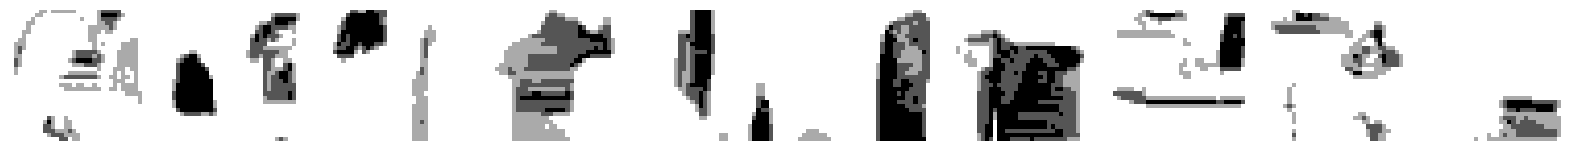

469/469 [==============================] - 57s 122ms/step - loss: 0.2053
Epoch 123/150
469/469 [==============================] - ETA: 0s - loss: 0.2053
Saved to ./temp/output/generated_img_122.png


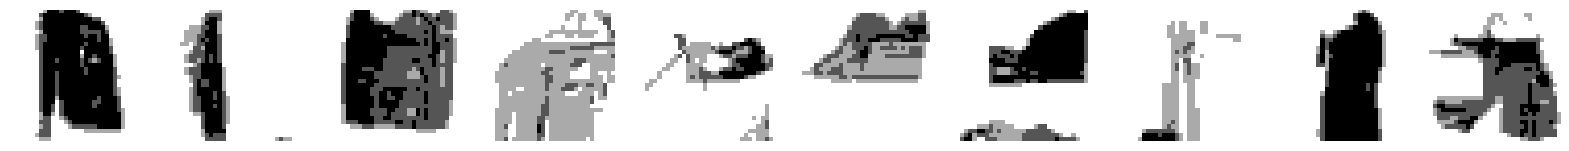

469/469 [==============================] - 57s 122ms/step - loss: 0.2053
Epoch 124/150
469/469 [==============================] - ETA: 0s - loss: 0.2053
Saved to ./temp/output/generated_img_123.png


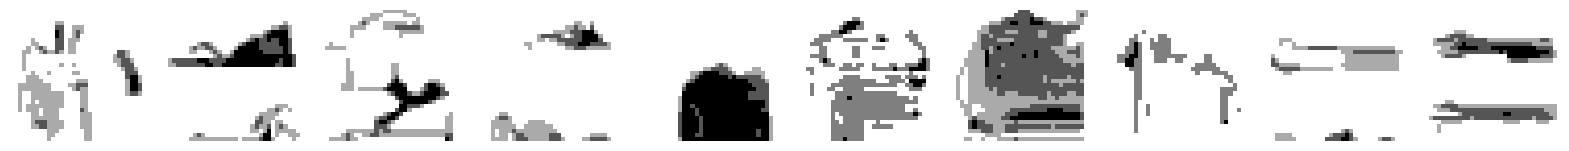

469/469 [==============================] - 57s 122ms/step - loss: 0.2053
Epoch 125/150
469/469 [==============================] - ETA: 0s - loss: 0.2052
Saved to ./temp/output/generated_img_124.png


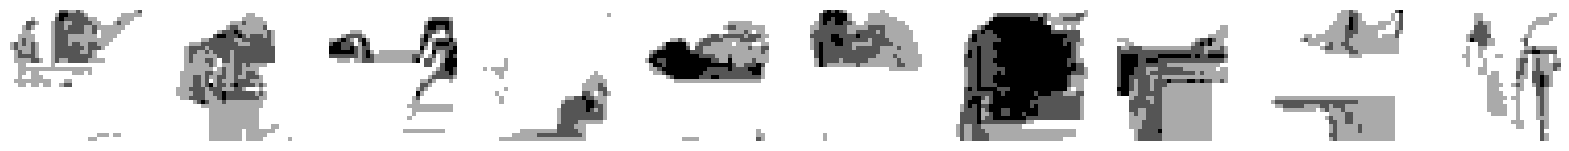

469/469 [==============================] - 59s 125ms/step - loss: 0.2052
Epoch 126/150
469/469 [==============================] - ETA: 0s - loss: 0.2052
Saved to ./temp/output/generated_img_125.png


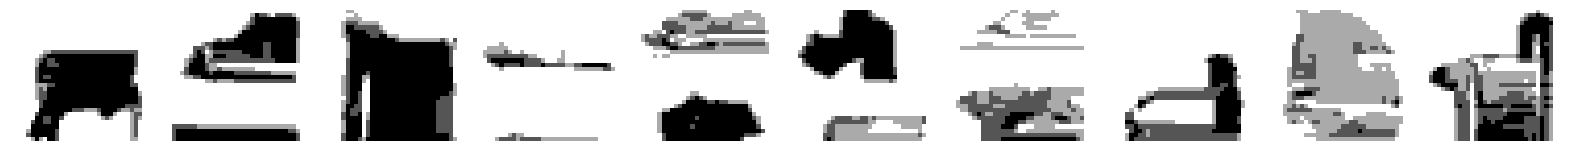

469/469 [==============================] - 58s 124ms/step - loss: 0.2052
Epoch 127/150
469/469 [==============================] - ETA: 0s - loss: 0.2051
Saved to ./temp/output/generated_img_126.png


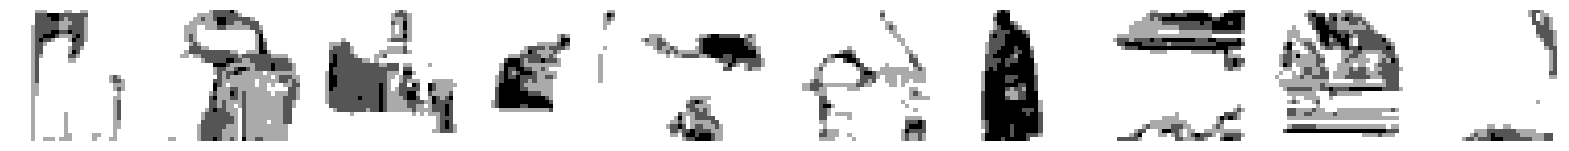

469/469 [==============================] - 58s 124ms/step - loss: 0.2051
Epoch 128/150
469/469 [==============================] - ETA: 0s - loss: 0.2051
Saved to ./temp/output/generated_img_127.png


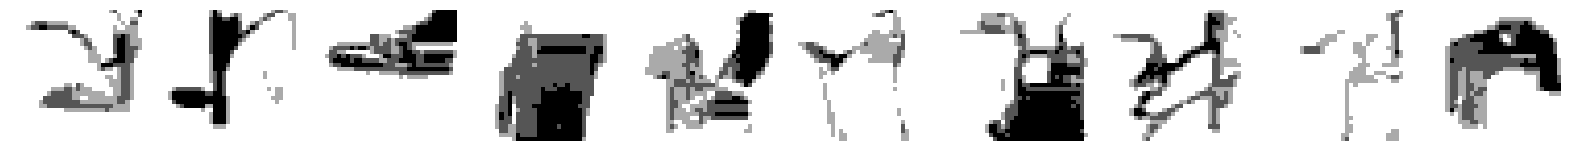

469/469 [==============================] - 58s 123ms/step - loss: 0.2051
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.2051
Saved to ./temp/output/generated_img_128.png


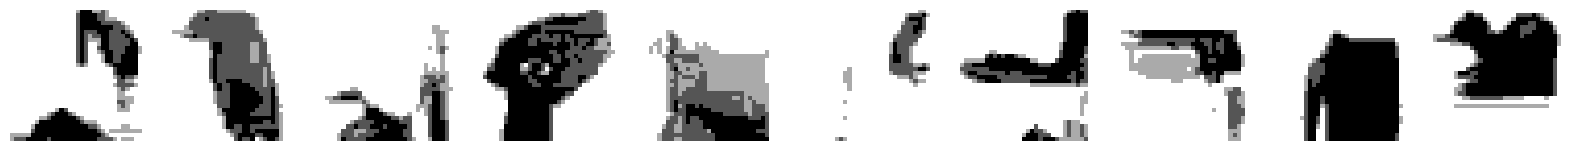

469/469 [==============================] - 58s 123ms/step - loss: 0.2051
Epoch 130/150
469/469 [==============================] - ETA: 0s - loss: 0.2051
Saved to ./temp/output/generated_img_129.png


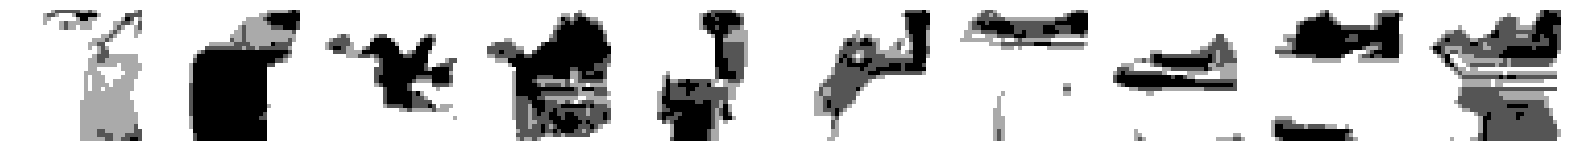

469/469 [==============================] - 57s 122ms/step - loss: 0.2051
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.2051
Saved to ./temp/output/generated_img_130.png


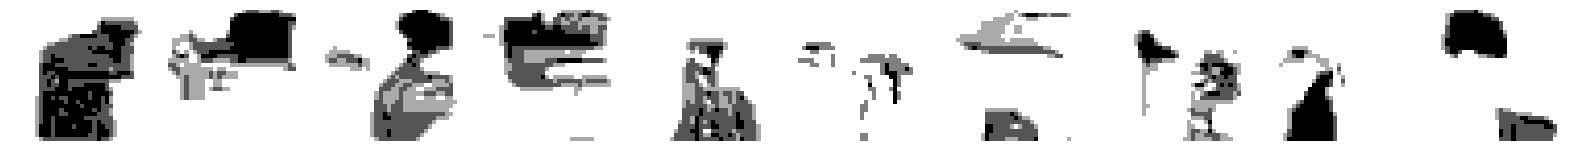

469/469 [==============================] - 58s 123ms/step - loss: 0.2051
Epoch 132/150
469/469 [==============================] - ETA: 0s - loss: 0.2049
Saved to ./temp/output/generated_img_131.png


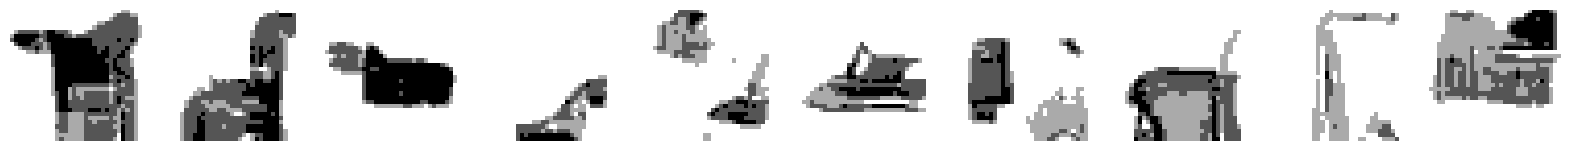

469/469 [==============================] - 58s 124ms/step - loss: 0.2049
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.2049
Saved to ./temp/output/generated_img_132.png


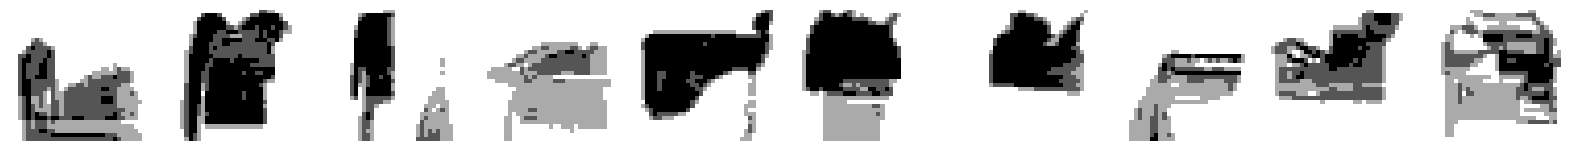

469/469 [==============================] - 57s 122ms/step - loss: 0.2049
Epoch 134/150
469/469 [==============================] - ETA: 0s - loss: 0.2050
Saved to ./temp/output/generated_img_133.png


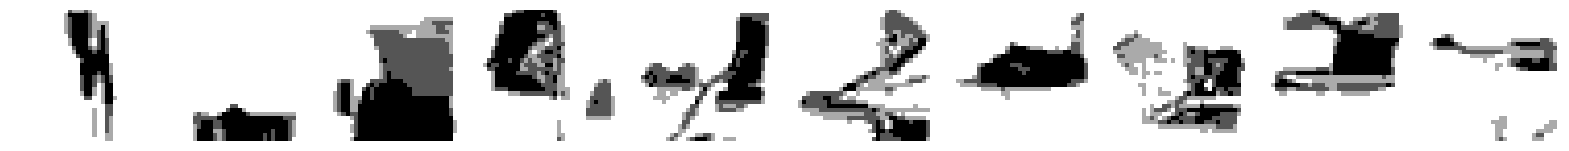

469/469 [==============================] - 57s 122ms/step - loss: 0.2050
Epoch 135/150
469/469 [==============================] - ETA: 0s - loss: 0.2049
Saved to ./temp/output/generated_img_134.png


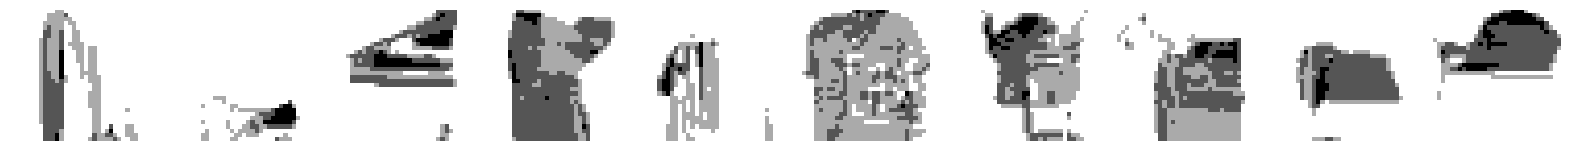

469/469 [==============================] - 57s 122ms/step - loss: 0.2049
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.2049
Saved to ./temp/output/generated_img_135.png


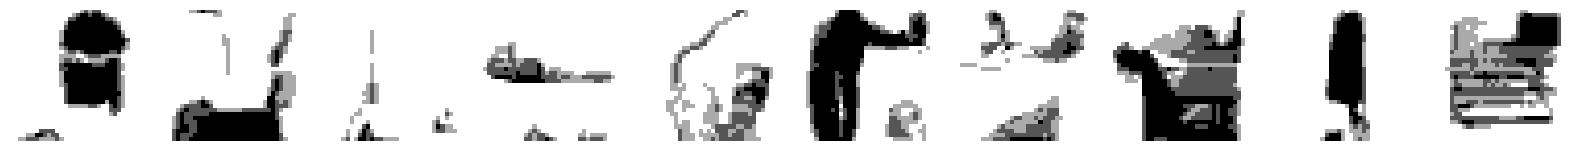

469/469 [==============================] - 57s 122ms/step - loss: 0.2049
Epoch 137/150
469/469 [==============================] - ETA: 0s - loss: 0.2048
Saved to ./temp/output/generated_img_136.png


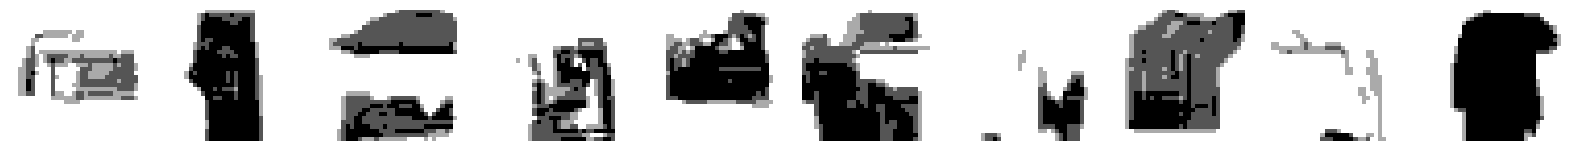

469/469 [==============================] - 57s 122ms/step - loss: 0.2048
Epoch 138/150
469/469 [==============================] - ETA: 0s - loss: 0.2048
Saved to ./temp/output/generated_img_137.png


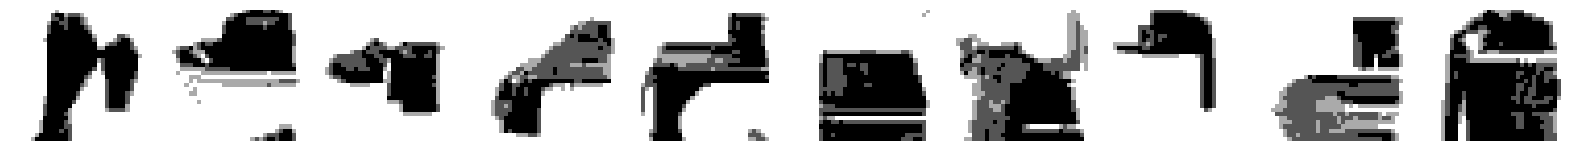

469/469 [==============================] - 57s 123ms/step - loss: 0.2048
Epoch 139/150
469/469 [==============================] - ETA: 0s - loss: 0.2047
Saved to ./temp/output/generated_img_138.png


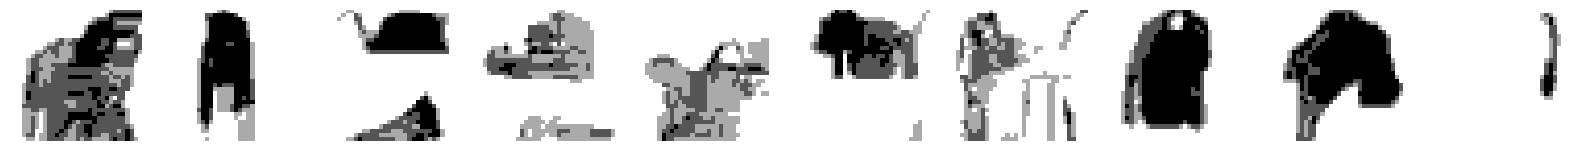

469/469 [==============================] - 57s 122ms/step - loss: 0.2047
Epoch 140/150
469/469 [==============================] - ETA: 0s - loss: 0.2047
Saved to ./temp/output/generated_img_139.png


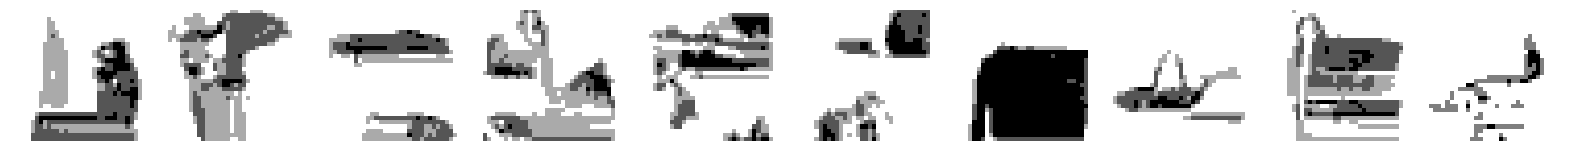

469/469 [==============================] - 58s 123ms/step - loss: 0.2047
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.2046
Saved to ./temp/output/generated_img_140.png


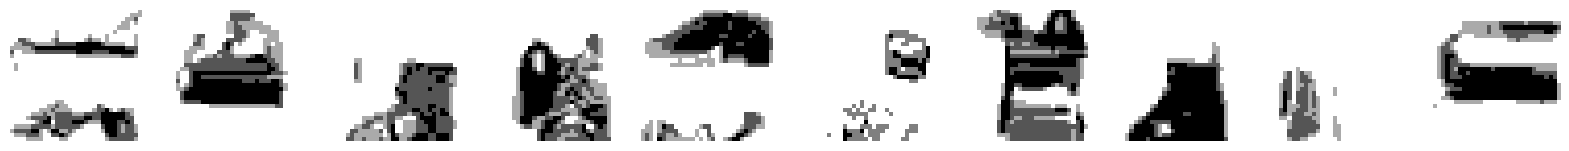

469/469 [==============================] - 58s 123ms/step - loss: 0.2046
Epoch 142/150
469/469 [==============================] - ETA: 0s - loss: 0.2047
Saved to ./temp/output/generated_img_141.png


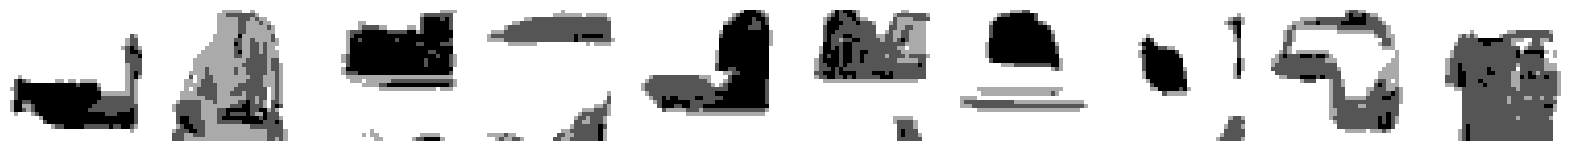

469/469 [==============================] - 58s 123ms/step - loss: 0.2047
Epoch 143/150
469/469 [==============================] - ETA: 0s - loss: 0.2046
Saved to ./temp/output/generated_img_142.png


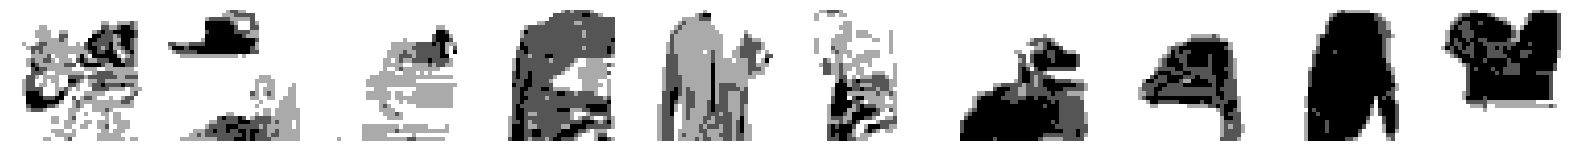

469/469 [==============================] - 57s 122ms/step - loss: 0.2046
Epoch 144/150
469/469 [==============================] - ETA: 0s - loss: 0.2046
Saved to ./temp/output/generated_img_143.png


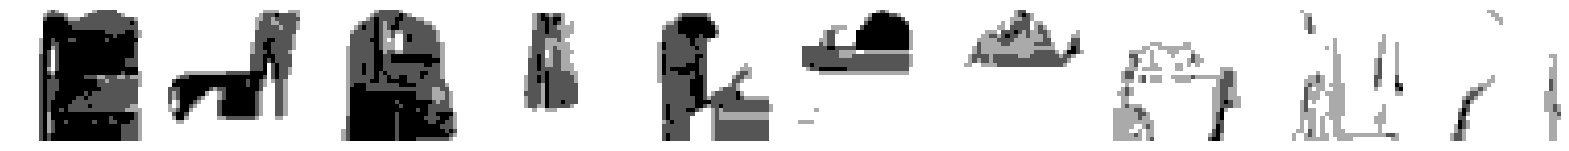

469/469 [==============================] - 58s 123ms/step - loss: 0.2046
Epoch 145/150
469/469 [==============================] - ETA: 0s - loss: 0.2045
Saved to ./temp/output/generated_img_144.png


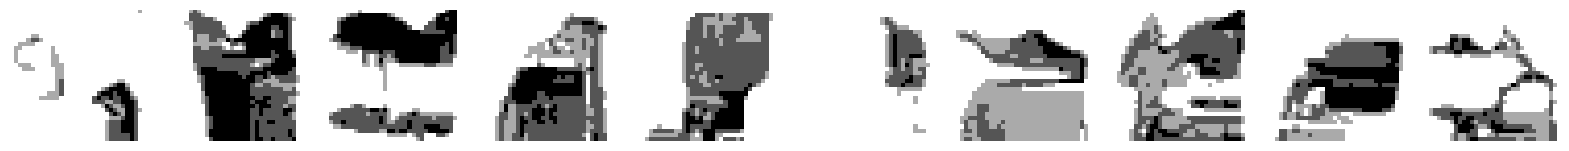

469/469 [==============================] - 57s 122ms/step - loss: 0.2045
Epoch 146/150
469/469 [==============================] - ETA: 0s - loss: 0.2045
Saved to ./temp/output/generated_img_145.png


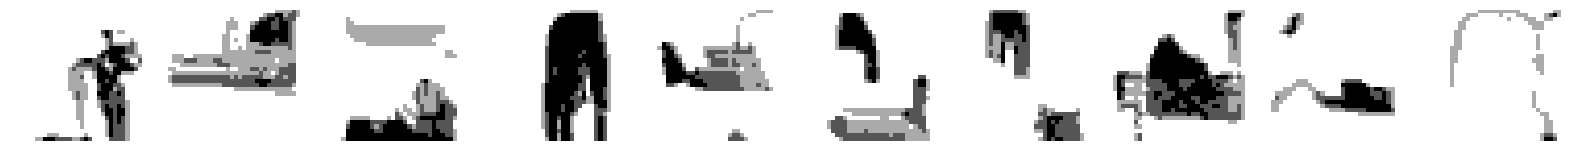

469/469 [==============================] - 57s 122ms/step - loss: 0.2045
Epoch 147/150
469/469 [==============================] - ETA: 0s - loss: 0.2045
Saved to ./temp/output/generated_img_146.png


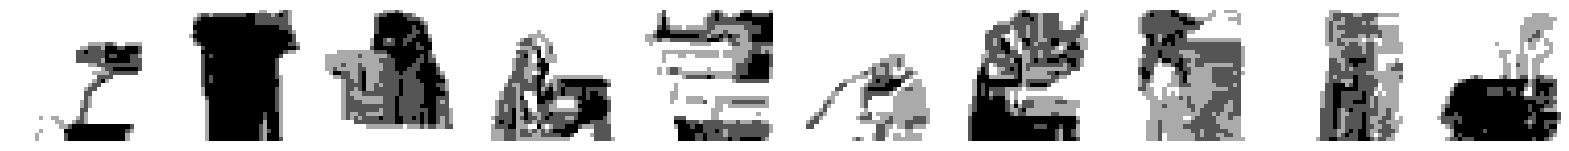

469/469 [==============================] - 57s 122ms/step - loss: 0.2045
Epoch 148/150
469/469 [==============================] - ETA: 0s - loss: 0.2045
Saved to ./temp/output/generated_img_147.png


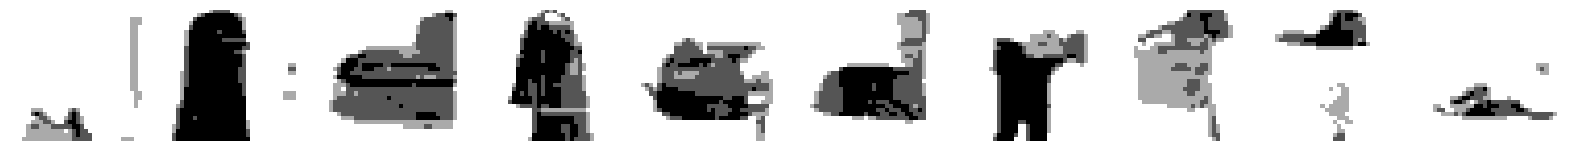

469/469 [==============================] - 57s 122ms/step - loss: 0.2045
Epoch 149/150
469/469 [==============================] - ETA: 0s - loss: 0.2044
Saved to ./temp/output/generated_img_148.png


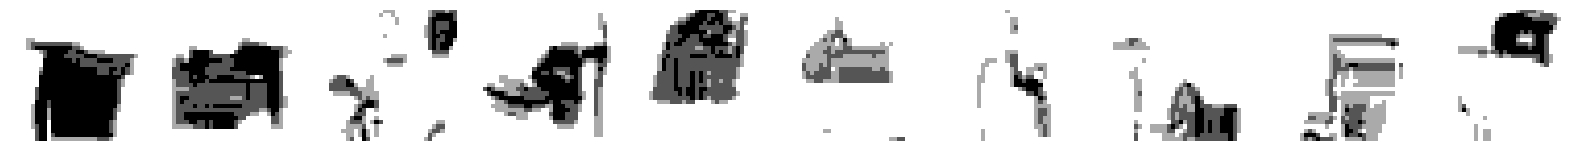

469/469 [==============================] - 57s 122ms/step - loss: 0.2044
Epoch 150/150
469/469 [==============================] - ETA: 0s - loss: 0.2045
Saved to ./temp/output/generated_img_149.png


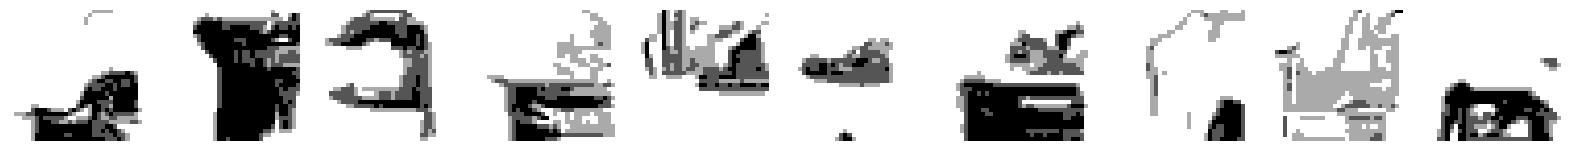

469/469 [==============================] - 58s 124ms/step - loss: 0.2045


In [6]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

Path("./temp/output").mkdir(parents=True, exist_ok=True)

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./temp/output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4.Generate Images

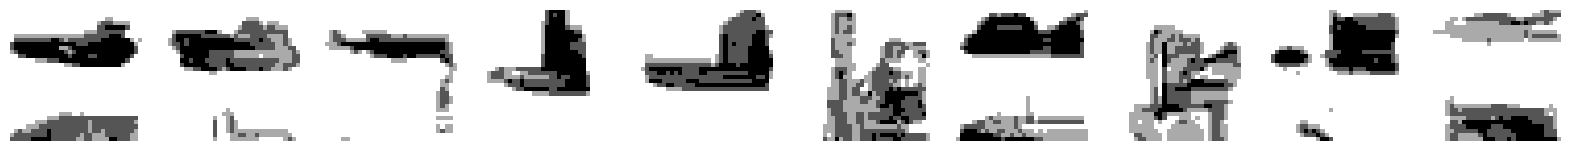

In [7]:
generated_images = img_generator_callback.generate(temperature=1.0)
display(generated_images)